## ✅ Résumé clair du projet

### 🎯 Objectif

Construire un modèle de **CCF Forward Looking (FL)** pour enrichir le calcul de l’**EAD** dans le cadre IFRS 9, en tenant compte des variables **macroéconomiques** et du **cycle de crédit**.
👉 Le but est de projeter un **CCF prévisionnel à 3 ans** à partir d’observations historiques et de données macro.

---

## 🧭 Étapes de travail recommandées (en Python)

### 1. 🔧 **Préparation des données**

* Charger les séries annuelles de CCF **observées (PiT)** par segment (dans Excel ou CSV)
* Charger les **CCF TTC (Through The Cycle)** servant de point d’ancrage
* Récupérer les séries **macro INSEE** (voir page 13 du PDF) :

  * PIB
  * Inflation
  * Chômage
  * Prix du logement

### 2. 📊 **Analyse exploratoire**

* Étudier la **stationnarité** des séries : `adfuller()` de `statsmodels`
* Visualiser les corrélations entre CCF et les variables macro (`heatmap`, `corr()`)
* Lisser éventuellement les séries via moyennes mobiles

### 3. 📈 **Modélisation**

Deux approches possibles :

#### A. Régression économique

> `CCF_PIT ~ macro_var1 + macro_var2 + …`

* Régression linéaire (`LinearRegression`)
* Ridge / Lasso pour éviter le sur-apprentissage
* Option : utiliser `statsmodels.OLS()` pour avoir les p-values

#### B. Approche hybride TTC + FL

> `CCF_proj = CCF_TTC + impact_macro`

* Calculer l’écart entre CCF\_PIT et CCF\_TTC (Δ)
* Modéliser Δ avec les variables macroéconomiques
* Ajouter la prévision de Δ au CCF\_TTC pour obtenir le CCF prévisionnel

---

### 4. 📉 **Projection**

* Créer un modèle `predict(X_macro_future)` pour les 3 prochaines années
* Appliquer le modèle sur des **scénarios macro projetés**
* Plafonner les valeurs à 100% (page 11)

---

### 5. 📁 Livrables attendus

* Un `main.py` exécutable
* Un `notebook` exploratoire
* Un fichier `ccf_model.py` avec la logique de modélisation
* Une **synthèse claire** (PDF, 3-4 pages) :

  * Hypothèses
  * Données utilisées
  * Modèles testés
  * Résultats / projections



### 📁 **Données\_CFF\_SERIE\_GLOBALE\_VF.csv**

| Variable               | Description                                                                                              | Remarque                                                                                                           |
| ---------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `date`                 | Date d’arrêté. Correspond à la génération 12 mois avant le défaut                                        | Les données sont trimestrielles. Tester aussi une modélisation annuelle, comme c’est le cas en production bancaire |
| `Indicateur_Moyen_1_5` | CCF brut moyen trimestriel pour la population des segments 1 à 5 (où le CCF est variable)                | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_5`   | % d’effectifs pour une date donnée (segments 1 à 5)                                                      | Sert à pondérer les périodes, utile pour améliorer la corrélation avec les variables macro                         |
| `Indicateur_Moyen_1_6` | CCF brut moyen trimestriel pour l’ensemble de la population (incluant le segment 6 avec CCF fixé à 100%) | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_6`   | % d’effectifs pour une date donnée (segments 1 à 6)                                                      | Sert à pondérer les périodes et tester l’apport du segment 6 malgré son CCF fixe                                   |

---

### 📁 **Données\_CFF\_PAR\_SEGMENT.csv**

| Variable                | Description                                                                       | Remarque                                                                                                                       |
| ----------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `Date`                  | Date d’arrêté (de 200903 à 202212)                                                | Tester modélisation trimestrielle **et** annuelle                                                                              |
| `Note_ref`              | Segment du CCF                                                                    | —                                                                                                                              |
| `Indicateur_moyen_Brut` | CCF moyen brut par segment                                                        | Variable cible                                                                                                                 |
| `PourcNote`             | % de la population d’un segment par rapport à l’ensemble des trimestres existants | Peu utile au début, mais à tester pour analyse de stationnarité                                                                |
| `PourcNoteCohorte`      | % dans un segment par rapport à toute la cohorte (6 segments)                     | Séries souvent instables, peut fausser les analyses. À tester avec pondération par les effectifs (ex : Weighted Least Squares) |
| `PourcNoteCohorte5`     | % dans un segment par rapport à la cohorte 1 à 5 (exclut segment 6 à CCF fixe)    | À privilégier pour éviter la distorsion induite par le segment 6                                                               |



# CHARGER LES DONNES

In [517]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


In [518]:
# Chargement des données
segment_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_PAR_SEGMENT.csv'
global_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_SERIE_GLOBALE_VF.csv'

df_global = pd.read_csv(global_path, sep=";")
df_segment = pd.read_csv(segment_path, sep=";")

# Statistiques descriptives
desc_global = df_global.info()
desc_segment = df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  60 non-null     object
 1   Indicateur_Moyen_1_5  60 non-null     object
 2   Effectif_Pourc_1_5    60 non-null     object
 3   Indicateur_Moyen_1_6  56 non-null     object
 4   Effectif_Pourc_1_6    56 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cod_prd_ref            360 non-null    object
 1   note_ref               360 non-null    int64 
 2   Indicateur_moyen_Brut  360 non-null    object
 3   PourcNote              360 non-null    object
 4   PourcNoteCohorte       360 non-null    object
 5   PourcNoteCohorte5      360 non-null    obj

In [519]:
macro_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/macrovariables/historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx'
df_macro = pd.read_excel(macro_path)

print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0           1980-03  0.0  0.0  5.3        0.0        NaN        NaN   
1           1980-06  0.0  0.0  5.3        0.0        0.0        0.0   
2           1980-09  0.0  0.0  5.4        0.0        0.0        0.0   
3           1980-12  0.0  0.0  5.6        0.0        0.0        0.0   
4           1981-03  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


# EXPLO DES DONNEES

In [520]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Nettoyage et conversion des colonnes numériques avec virgules
for col in ['Indicateur_Moyen_1_5', 'Effectif_Pourc_1_5', 'Indicateur_Moyen_1_6', 'Effectif_Pourc_1_6']:
    df_global[col] = df_global[col].str.replace(',', '.').astype(float)

for col in ['Indicateur_moyen_Brut', 'PourcNote', 'PourcNoteCohorte', 'PourcNoteCohorte5']:
    df_segment[col] = df_segment[col].str.replace(',', '.').astype(float)

# Conversion des dates
df_global['date'] = pd.to_datetime(df_global['date'])

# Nettoyage des espaces et conversion en date trimestrielle
df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))

# Affichage des dates uniques triées pour vérification
df_segment['date'].sort_values().unique()

# Statistiques descriptives
desc_global = df_global.describe()
desc_segment = df_segment.describe()

print(desc_global)
print("----")
print(desc_segment)

                      date  Indicateur_Moyen_1_5  Effectif_Pourc_1_5  \
count                   60             60.000000           60.000000   
mean   2016-01-05 21:36:00              0.710161            0.016667   
min    2009-01-01 00:00:00              0.475551            0.008257   
25%    2012-01-09 06:00:00              0.607004            0.012825   
50%    2016-01-05 12:00:00              0.690971            0.016108   
75%    2020-01-01 18:00:00              0.820344            0.021441   
max    2023-01-10 00:00:00              0.970606            0.024525   
std                    NaN              0.123135            0.004892   

       Indicateur_Moyen_1_6  Effectif_Pourc_1_6  
count             56.000000           56.000000  
mean               0.863108            0.017857  
min                0.749491            0.009202  
25%                0.825782            0.014296  
50%                0.856909            0.017892  
75%                0.910321            0.021149  
m

/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_2058/3820830927.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))


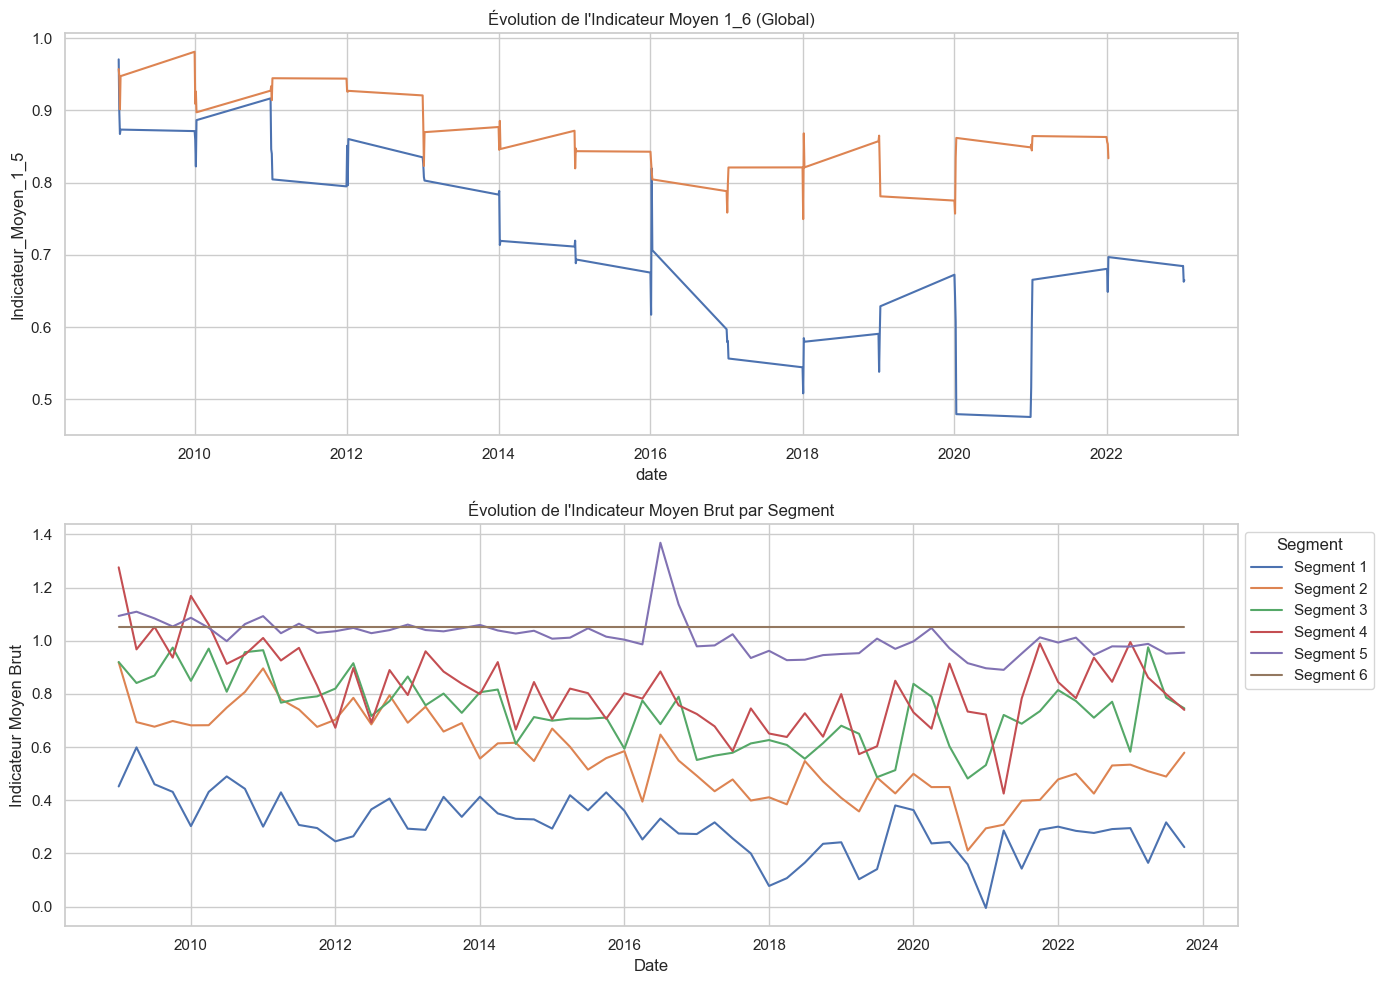

In [521]:
# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



#### DONNEES INSEE

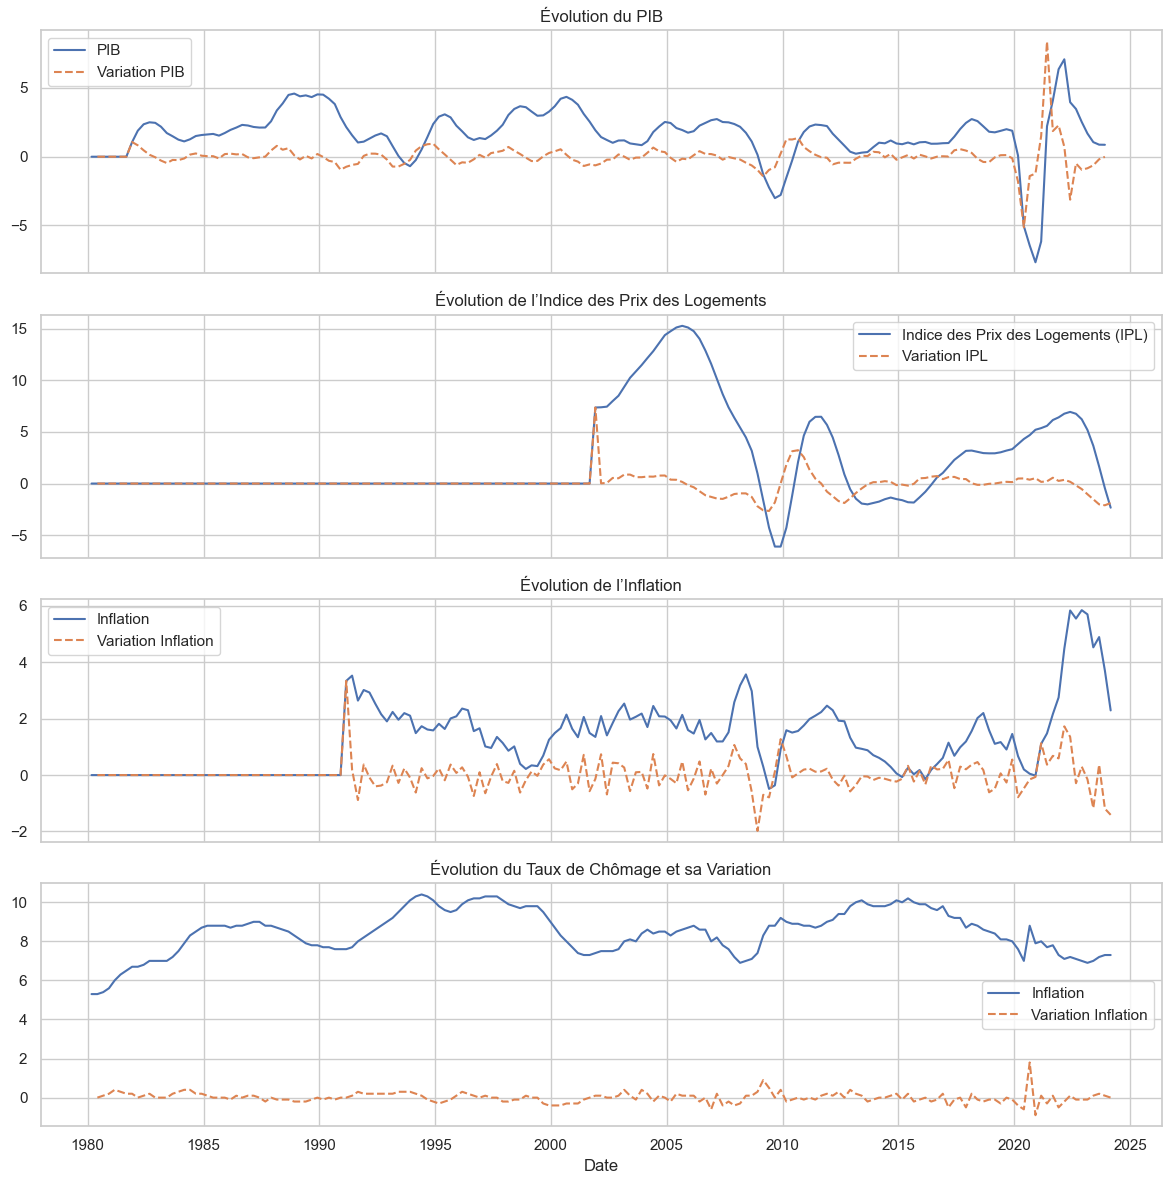

In [522]:
# Tracer PIB, IPL et Inflation avec leurs variations
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"])

# PIB
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB"], label="PIB")
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB_diff1"], label="Variation PIB", linestyle='--')
ax[0].set_title("Évolution du PIB")
ax[0].legend()
ax[0].grid(True)

# IPL
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL"], label="Indice des Prix des Logements (IPL)" )
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL_diff1"], label="Variation IPL", linestyle='--')
ax[1].set_title("Évolution de l’Indice des Prix des Logements")
ax[1].legend()
ax[1].grid(True)

# Inflation
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation"], label="Inflation")
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation_diff1"], label="Variation Inflation", linestyle='--')
ax[2].set_title("Évolution de l’Inflation")
ax[2].legend()
ax[2].grid(True)

# Inflation
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH"], label="Inflation")
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH_diff1"], label="Variation Inflation", linestyle='--')
ax[3].set_title("Évolution du Taux de Chômage et sa Variation")
ax[3].legend()
ax[3].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


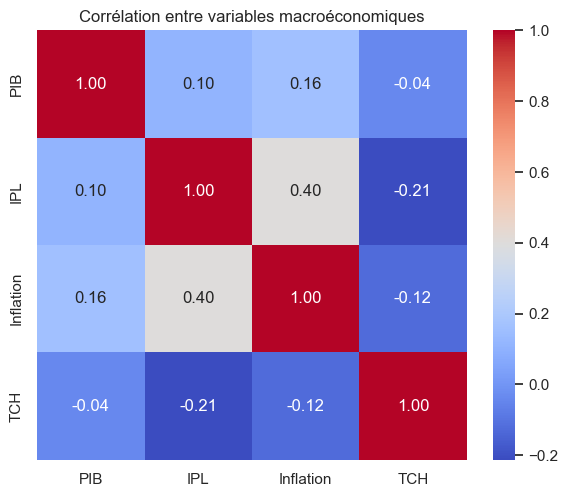

In [523]:
# Corrélation simple entre les 4 variables macro (en niveau)
simple_corr = df_macro[["PIB", "IPL", "Inflation", "TCH"]].corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(6, 5))
sns.heatmap(simple_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()


In [524]:
print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0        1980-03-01  0.0  0.0  5.3        0.0        NaN        NaN   
1        1980-06-01  0.0  0.0  5.3        0.0        0.0        0.0   
2        1980-09-01  0.0  0.0  5.4        0.0        0.0        0.0   
3        1980-12-01  0.0  0.0  5.6        0.0        0.0        0.0   
4        1981-03-01  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


## FORMATAGE

##### Mise à jour des dates 

In [525]:
# Créer une fonction de conversion fin → début de trimestre
def start_of_quarter(date):
    if date.month == 3:
        return pd.Timestamp(year=date.year, month=1, day=1)
    elif date.month == 6:
        return pd.Timestamp(year=date.year, month=4, day=1)
    elif date.month == 9:
        return pd.Timestamp(year=date.year, month=7, day=1)
    elif date.month == 12:
        return pd.Timestamp(year=date.year, month=10, day=1)
    else:
        return pd.NaT

# S'assurer que la colonne est au format datetime
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], errors='coerce')

# Appliquer la transformation sur df_macro
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].apply(start_of_quarter)


In [526]:
# Reformatage : d'abord en string inversé, puis en datetime
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].dt.strftime("%d-%m-%Y")
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], format="%d-%m-%Y")

# Filtrer les dates de l'année 2009 pour les deux DataFrames
dates_segment_2009 = df_segment[df_segment["date"].dt.year == 2009]["date"].unique()
dates_global_2009 = df_global[df_global["date"].dt.year == 2009]["date"].unique()
dates_macro_2009 = df_macro[df_macro["date_dernier_mois"].dt.year == 2009]["date_dernier_mois"].unique()

# Créer un tableau comparatif
df_dates_2009 = pd.DataFrame({
    "Dates df_global (2009)": dates_global_2009,
    "Dates df_segment (2009)": dates_segment_2009,
    "Dates df_macro (2009)": dates_macro_2009
})

print(df_dates_2009)

  Dates df_global (2009) Dates df_segment (2009) Dates df_macro (2009)
0             2009-01-01              2009-01-01            2009-01-01
1             2009-01-04              2009-04-01            2009-04-01
2             2009-01-07              2009-07-01            2009-07-01
3             2009-01-10              2009-10-01            2009-10-01


##### Segmenter les DF

In [527]:
# Créer un DataFrame par segment (valeur unique de note_ref)
segments_dfs = {
    f"segment_{segment}": df_segment[df_segment["note_ref"] == segment].reset_index(drop=True)
    for segment in sorted(df_segment["note_ref"].unique())
}

# Afficher les noms des segments et un aperçu d’un segment
segment_names = list(segments_dfs.keys())

segment_1 = segments_dfs[segment_names[0]]
segment_2 = segments_dfs[segment_names[1]]
segment_3 = segments_dfs[segment_names[2]]
segment_4 = segments_dfs[segment_names[3]]
segment_5 = segments_dfs[segment_names[4]]
segment_6 = segments_dfs[segment_names[5]]

### Merged avec MACRO 

In [528]:
df_macro_lag = df_macro.copy()

df_macro_lag['PIB_lag1'] = df_macro['PIB'].shift(1)
df_macro_lag['IPL_lag1'] = df_macro['IPL_diff1'].shift(1)
df_macro_lag['Inflation_lag1'] = df_macro['Inflation_diff1'].shift(1)
df_macro_lag['TCH_lag1'] = df_macro['TCH_diff1'].shift(1)

# # Pivot pour obtenir les colonnes Indicateur_moyen_Brut_1 à 6
# pivot_df = df_segment.pivot(index="date", columns="note_ref", values=["Indicateur_moyen_Brut", "PourcNoteCohorte"])
# pivot_df.columns = [f"Indicateur_moyen_Brut_{int(col)}" for col in pivot_df.columns]

# Pivot pour transformer les colonnes par segment (note_ref)
pivot_df = df_segment.pivot(index="date", columns="note_ref", values=["Indicateur_moyen_Brut", "PourcNoteCohorte5"])

# Aplatir les colonnes multi-index
pivot_df.columns = [f"{var}_{int(note)}" for var, note in pivot_df.columns]

# (optionnel) Réinitialiser l’index si tu veux une colonne date
# pivot_df = pivot_df.reset_index()

# Fusionner avec les données macroéconomiques
df_macro_lag = df_macro_lag.rename(columns={"date_dernier_mois": "date"})
df_merged = pivot_df.merge(df_macro_lag, on="date", how="left")

# Créer une copie sans la colonne Indicateur_moyen_Brut_6
df_merged_6 = df_merged.drop(columns=["Indicateur_moyen_Brut_6"], inplace=False)

# Définir "date" comme index
df_merged.set_index("date", inplace=True)

# Afficher un aperçu des données fusionnées
print(df_merged.head())


            Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  Indicateur_moyen_Brut_6  \
date                                  

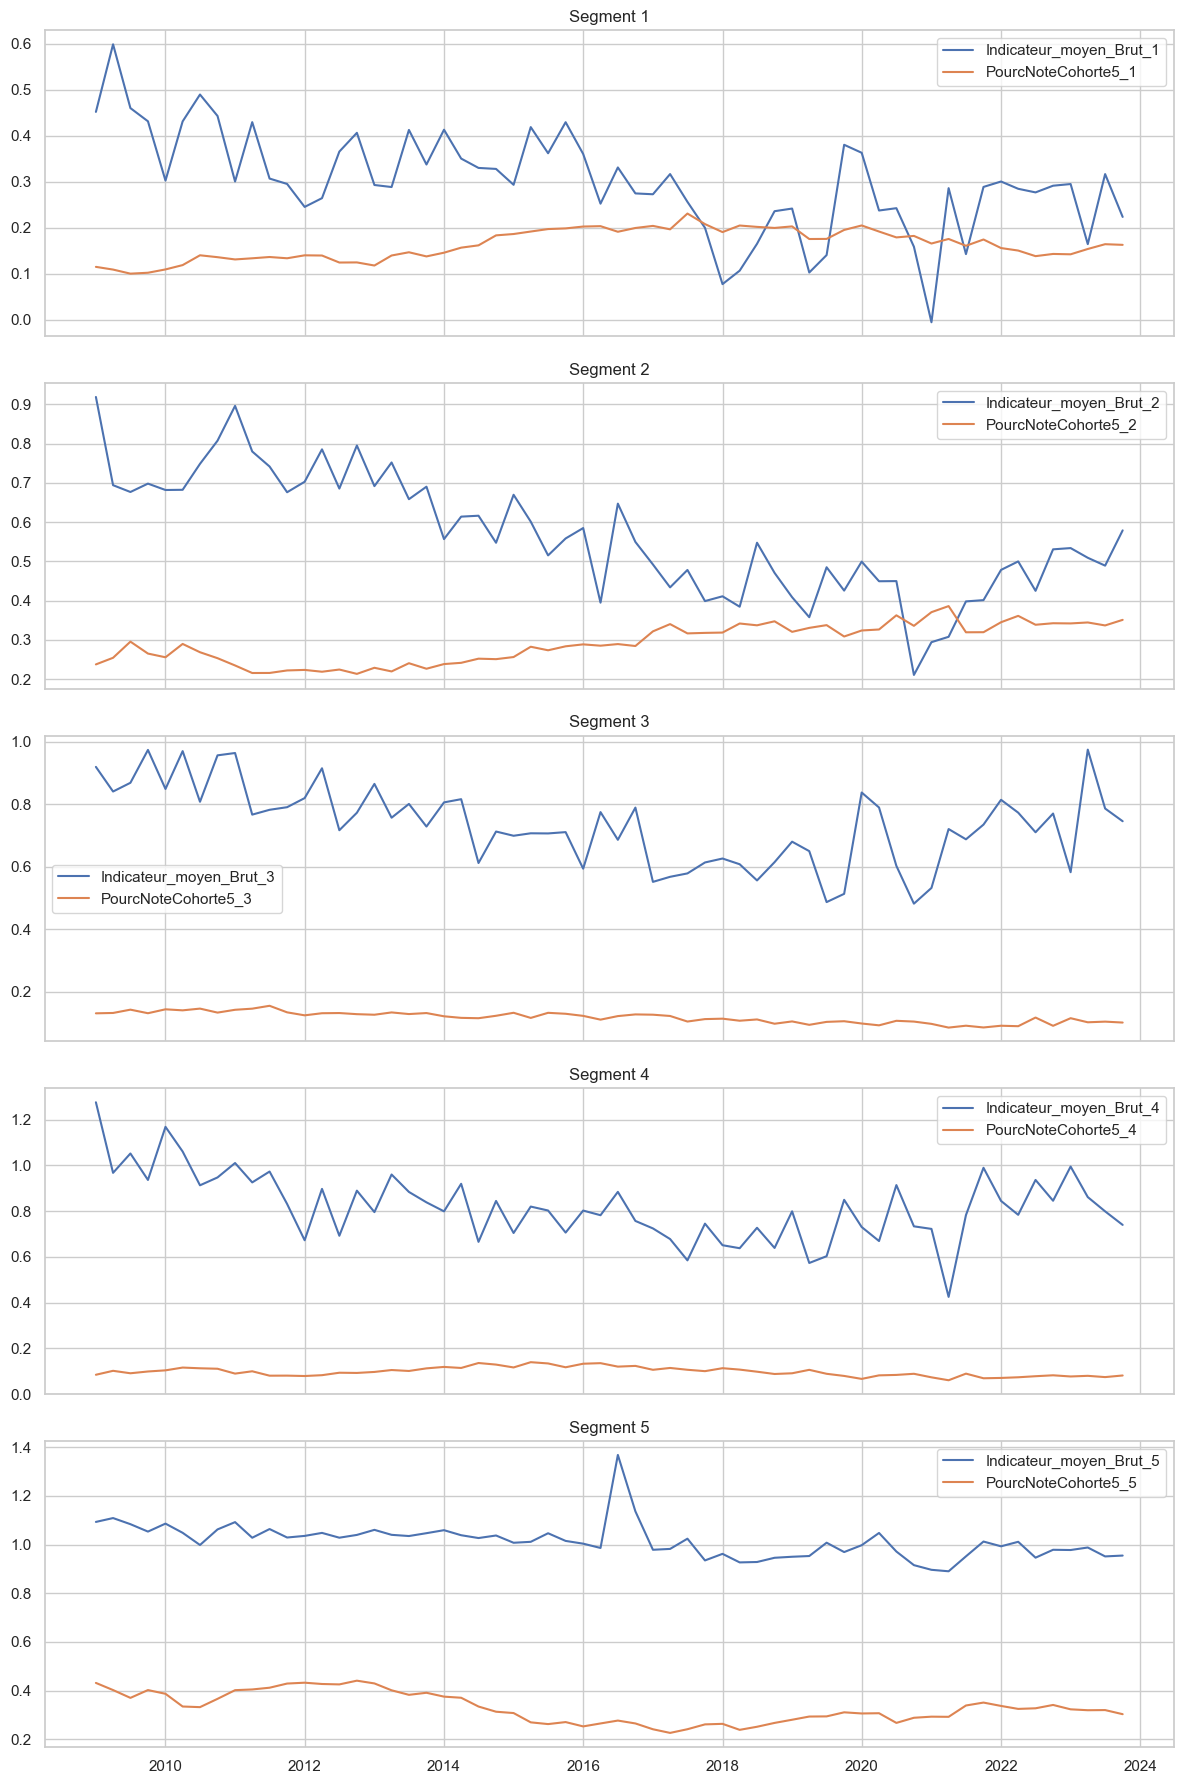

In [529]:
import pandas as pd
import matplotlib.pyplot as plt

# Création des subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 18), sharex=True)

for i in range(1, 6):
    ax = axes[i-1]
    ax.plot(df_merged.index, df_merged[f'Indicateur_moyen_Brut_{i}'], label=f'Indicateur_moyen_Brut_{i}')
    ax.plot(df_merged.index, df_merged[f'PourcNoteCohorte5_{i}'], label=f'PourcNoteCohorte5_{i}')
    ax.set_title(f'Segment {i}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## ANALYSE

### GLOBAL

#### Autocorrelation

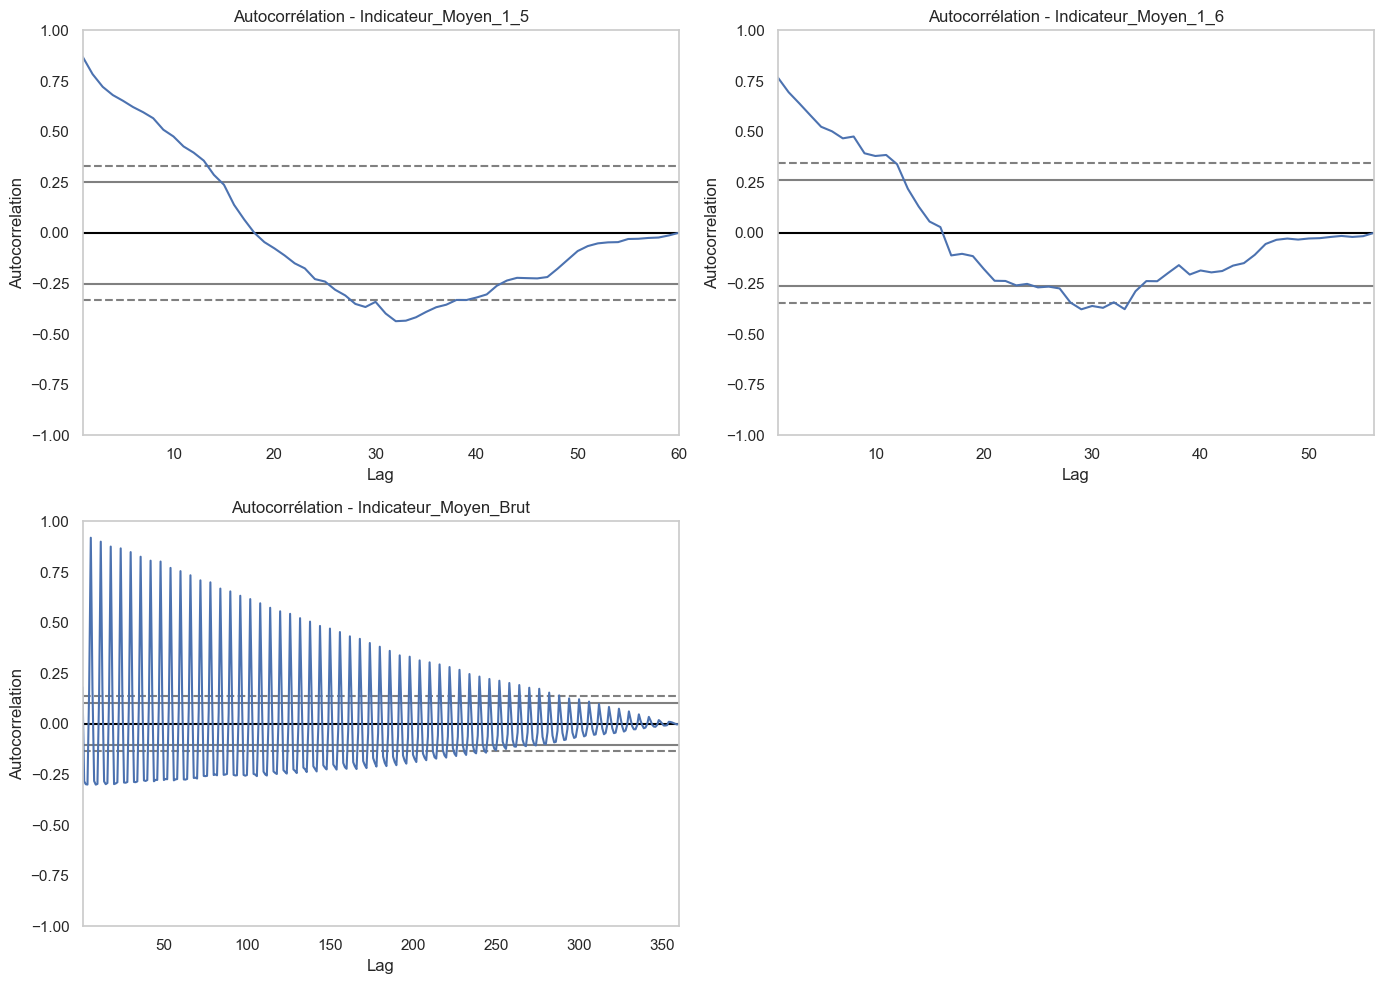

In [530]:
# Tracer les autocorrélations
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
autocorrelation_plot(df_global["Indicateur_Moyen_1_5"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_5")

plt.subplot(2, 2, 2)
autocorrelation_plot(df_global["Indicateur_Moyen_1_6"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_6")

plt.subplot(2, 2, 3)
autocorrelation_plot(df_segment["Indicateur_moyen_Brut"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_Brut")


plt.tight_layout()
plt.show()

#### Stationnarité

In [531]:
# Appliquer les tests ADF en utilisant les bons DataFrames pour chaque série

# Création de dictionnaires d'entrée
series_sources = {
    "Indicateur_Moyen_1_5": df_global["Indicateur_Moyen_1_5"].dropna(),  # df_global
    "Indicateur_Moyen_1_6": df_global["Indicateur_Moyen_1_6"].dropna(),  # df_global
    "Indicateur_Moyen_Brut": df_segment["Indicateur_moyen_Brut"].dropna()  # df_segmentdf_segment["Indicateur_moyen_Brut"].dropna() df_segment["Indicateur_moyen_Brut"].dropna()  #  # df_segment
}
# Lancer le test ADF
adf_results_corrected = []

for name, series in series_sources.items():
    adf = adfuller(series)
    adf_results_corrected.append({
        "Série": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

adf_df_corrected = pd.DataFrame(adf_results_corrected)
adf_df_corrected

,Série,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,Indicateur_Moyen_1_5,-2.371826,0.149847,-3.546395,-2.911939,-2.593652
1,Indicateur_Moyen_1_6,-2.128698,0.233133,-3.557709,-2.916770,-2.596222
2,Indicateur_Moyen_Brut,-2.053515,0.263612,-3.449616,-2.870028,-2.571292


#### Règles de stationnarité

p-value > 0.05, donc on ne rejette pas l’hypothèse nulle :


👉 pas stationnaire au seuil de 5%.


Statistique ADF > valeur critique à 5%,

👉 pas stationnaire au seuil de 5%.

### Par segment

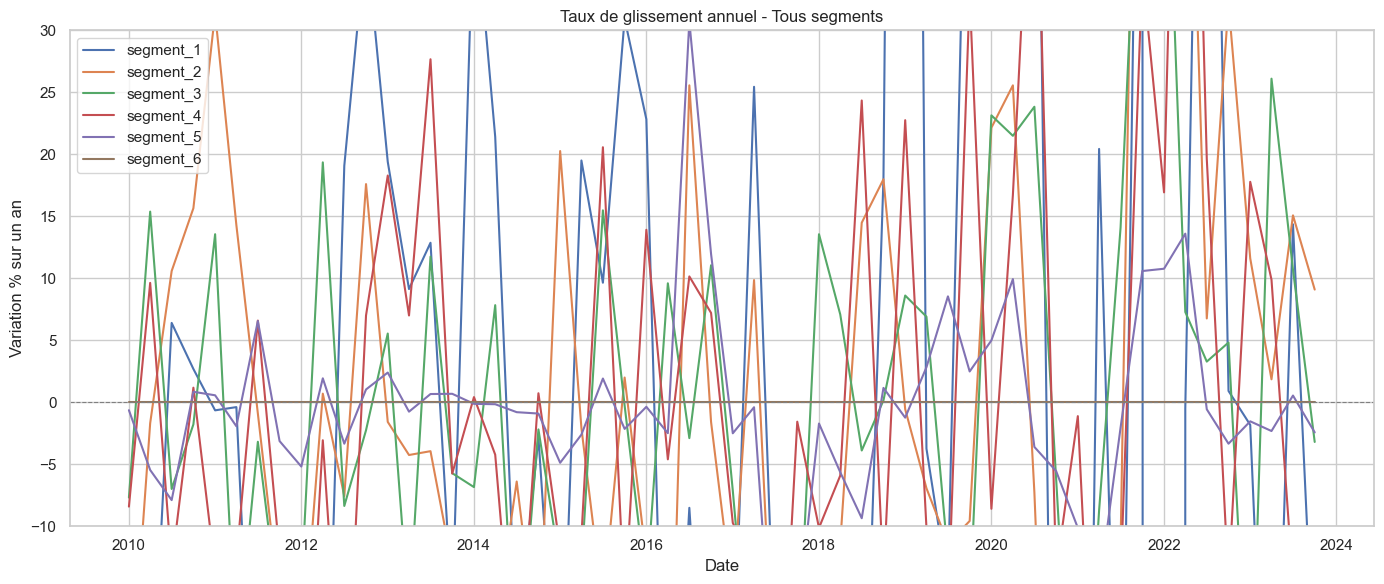

In [532]:
# Réimporter bibliothèques nécessaires après reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calcul du glissement annuel pour tous les segments
glissement_annuel_dfs = {}
for name, df in segments_dfs.items():
    df_sorted = df.sort_values("date").reset_index(drop=True).copy()
    df_sorted["glissement_annuel"] = (df_sorted["Indicateur_moyen_Brut"] / df_sorted["Indicateur_moyen_Brut"].shift(4) - 1) * 100
    glissement_annuel_dfs[name] = df_sorted.dropna().reset_index(drop=True)

# Tracer toutes les séries de glissement annuel sur une seule grille
plt.figure(figsize=(14, 6))
for name, df in glissement_annuel_dfs.items():
    plt.plot(df["date"], df["glissement_annuel"], label=name)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Taux de glissement annuel - Tous segments")
plt.xlabel("Date")
plt.ylabel("Variation % sur un an")
plt.ylim(-10, 30)
plt.legend()
plt.tight_layout()
plt.show()


segment_1 60
segment_2 60
segment_3 60
segment_4 60
segment_5 60
segment_6 60


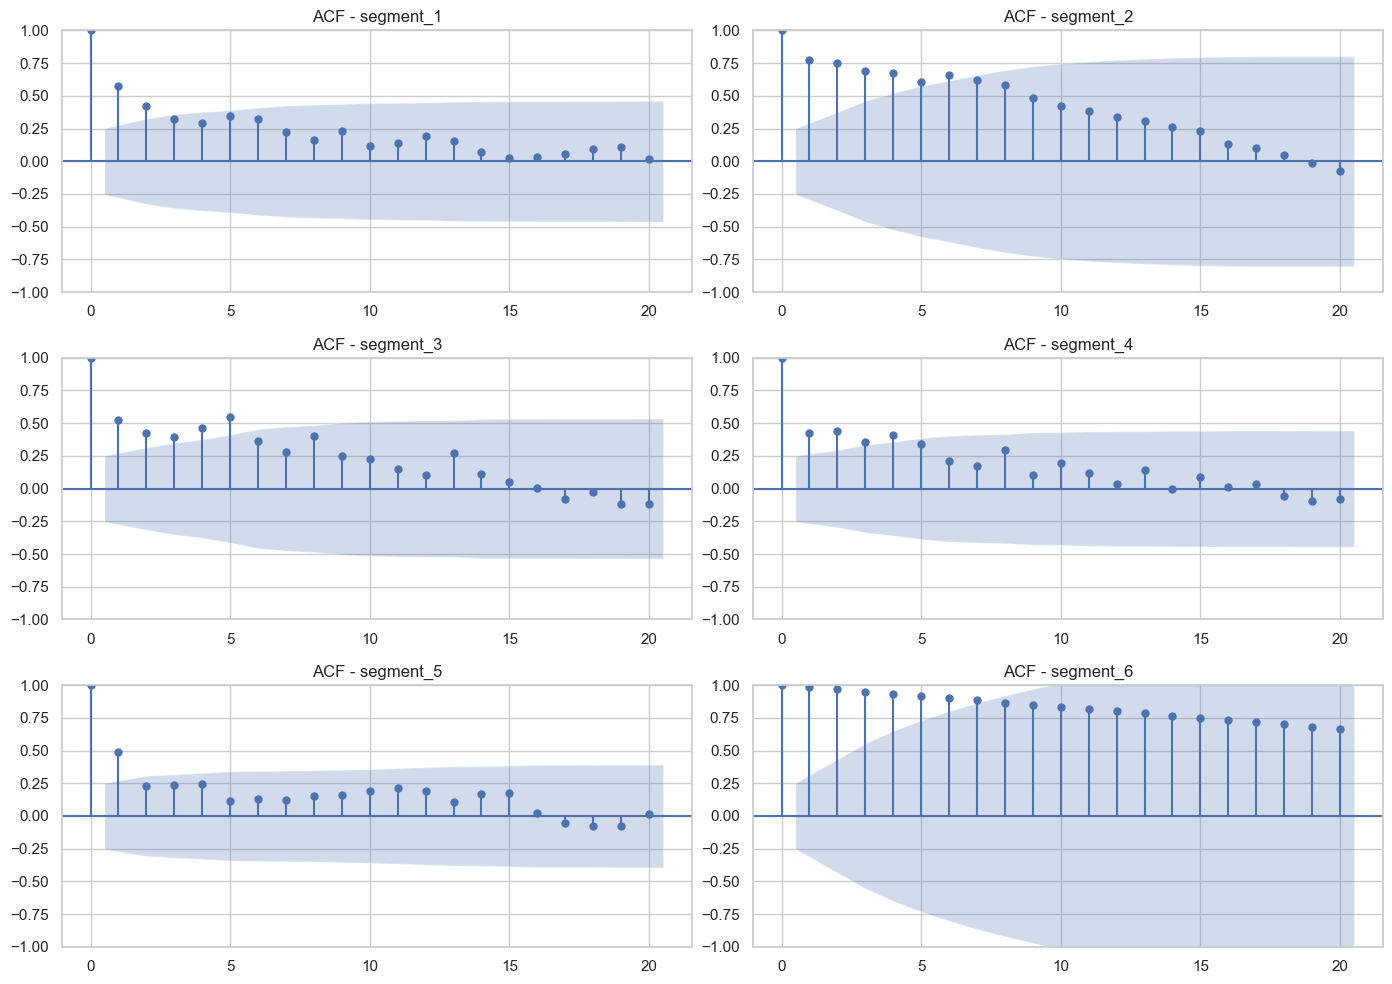

,Segment,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,segment_1,-3.983272,0.001501,-3.546395,-2.911939,-2.593652
1,segment_2,-1.833660,0.363883,-3.548494,-2.912837,-2.594129
2,segment_3,-2.228654,0.196010,-3.565624,-2.920142,-2.598015
3,segment_4,-5.324879,0.000005,-3.546395,-2.911939,-2.593652
4,segment_5,-4.430622,0.000262,-3.546395,-2.911939,-2.593652
5,segment_6,NaN,NaN,NaN,NaN,NaN


In [533]:
# Utiliser segment_names et segments_dfs directement, avec vérification du nombre d'observations

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Initialiser résultats
adf_results = []

# Créer la grille de sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()
plot_index = 0

for name in segment_names:
    print(name, len(segments_dfs[name]["Indicateur_moyen_Brut"].dropna()))

# Itérer sur les noms de segments existants
for name in segment_names:
    df = segments_dfs[name]
    series = df["Indicateur_moyen_Brut"].dropna()

    # Tester la taille de la série avant de tracer l'ACF
    if len(series) > 20:
        plot_acf(series, ax=axes[plot_index], lags=20, alpha=0.05)
        axes[plot_index].set_title(f"ACF - {name}")
        plot_index += 1

    # Effectuer le test ADF même si la série est courte
    try:
        adf = adfuller(series)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

# Supprimer les axes inutilisés
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Créer un tableau des résultats ADF
adf_df = pd.DataFrame(adf_results)
adf_df


| Segment   | ACF persistante | ADF p-value | Stationnaire ? | Action recommandée  |
| --------- | --------------- | ----------- | -------------- | ------------------- |
| Segment 1 | Moyenne         | 0.0015      | ✅ Oui          | OK                  |
| Segment 2 | Forte           | 0.36        | ❌ Non          | Différencier        |
| Segment 3 | Moyenne à forte | 0.196       | ❌ Non          | Différencier        |
| Segment 4 | Moyenne         | 0.000005    | ✅ Oui          | OK                  |
| Segment 5 | Faible          | 0.00026     | ✅ Oui          | OK                  |
| Segment 6 | Très forte      | NaN         | ❓ Invalide     | Vérifier / nettoyer |


### Pour les MACRO

In [534]:
# Filtrer les données de df_macro de 2009 à aujourd'hui
df_macro = df_macro[df_macro['date_dernier_mois'] >= '2009-01-01']

# Afficher un aperçu des données filtrées
print(df_macro)

    date_dernier_mois       PIB       IPL  TCH  Inflation  PIB_diff1  \
116        2009-01-01 -1.286788 -1.624415  8.3   0.301692  -1.430885   
117        2009-04-01 -2.243102 -4.278729  8.8  -0.489570  -0.956314   
118        2009-07-01 -3.012266 -6.103516  8.8  -0.362976  -0.769164   
119        2009-10-01 -2.782833 -6.105367  9.2   0.914470   0.229433   
120        2010-01-01 -1.517665 -4.278209  9.0   1.589859   1.265167   
..                ...       ...       ...  ...        ...        ...   
172        2023-01-01  1.687226  5.190174  6.9   5.701873  -0.838929   
173        2023-04-01  1.061365  3.664003  7.0   4.531319  -0.625860   
174        2023-07-01  0.876149  1.650038  7.2   4.896221  -0.185217   
175        2023-10-01  0.868858 -0.455149  7.3   3.705326  -0.007291   
176        2024-01-01       NaN -2.335217  7.3   2.294717        NaN   

     IPL_diff1  TCH_diff1  Inflation_diff1  
116  -2.593841        0.9        -0.697982  
117  -2.654313        0.5        -0.791262  


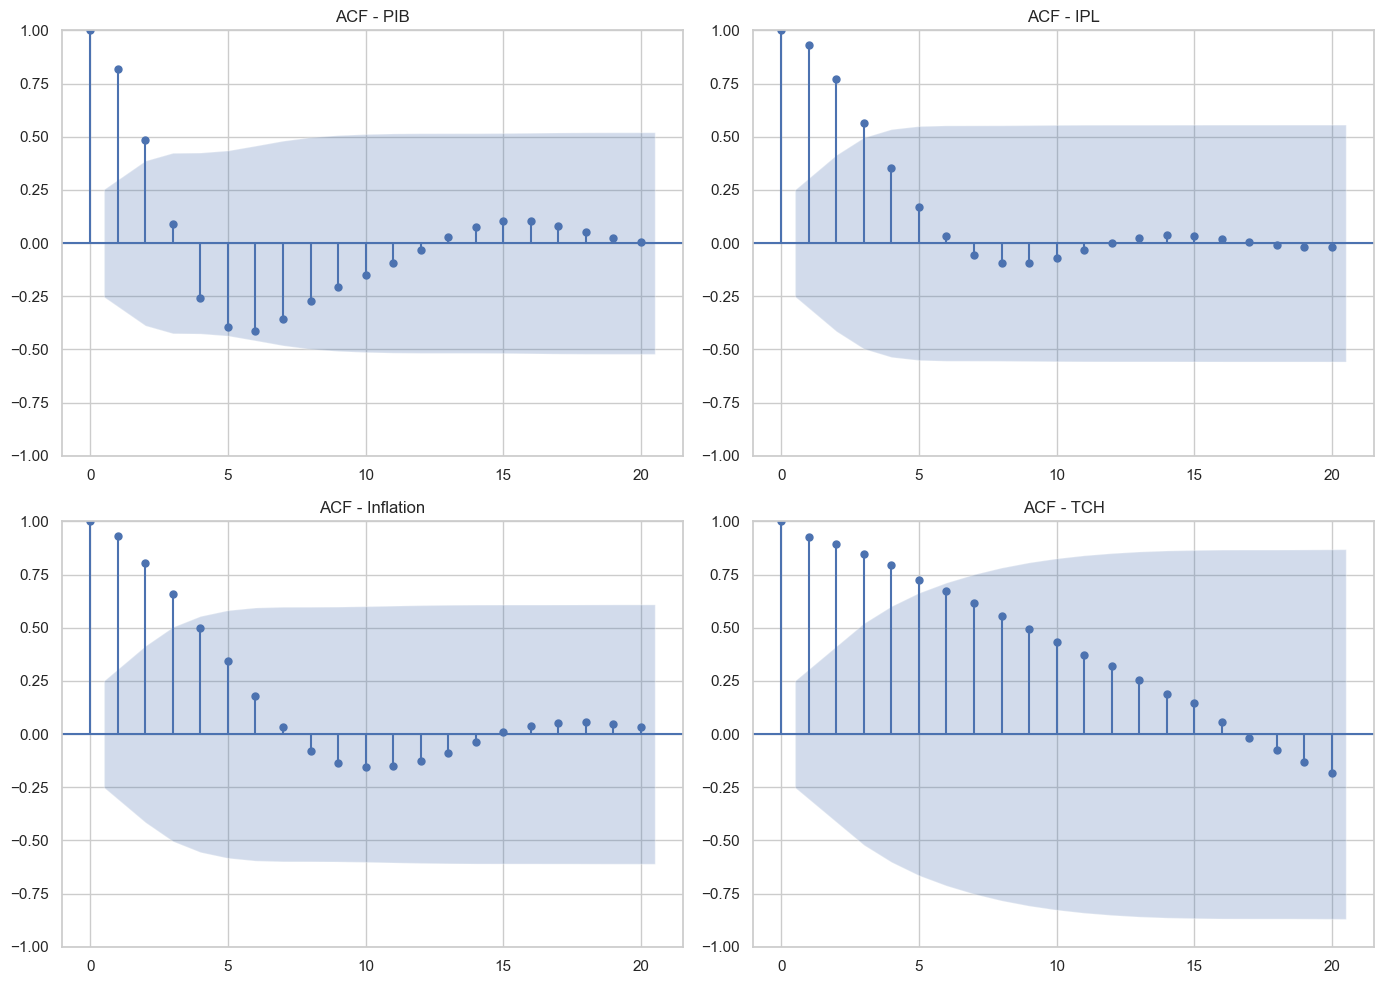

,Variable,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,PIB,-3.327967,0.013674,-3.571472,-2.922629,-2.599336
1,IPL,-1.542183,0.512550,-3.568486,-2.921360,-2.598662
2,Inflation,-1.320889,0.619562,-3.562879,-2.918973,-2.597393
3,TCH,-0.270556,0.929572,-3.546395,-2.911939,-2.593652


In [535]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

# Initialiser les résultats
adf_results_macro = []

# Créer la grille de sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
plot_index = 0

# Itérer sur les variables macroéconomiques
for var in ["PIB", "IPL", "Inflation", "TCH"]:
    series = df_macro[var].dropna()

    # Tracer l'ACF
    plot_acf(series, ax=axes[plot_index], lags=20, alpha=0.05)
    axes[plot_index].set_title(f"ACF - {var}")
    plot_index += 1

    # Effectuer le test ADF
    try:
        adf = adfuller(series)
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except Exception as e:
        adf_results_macro.append({
            "Variable": var,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None,
            "Erreur": str(e)
        })

plt.tight_layout()
plt.show()

# Créer un tableau des résultats ADF
adf_df_macro = pd.DataFrame(adf_results_macro)
adf_df_macro


*| Variable      | Stationnarité (Test ADF) | ACF Interprétation       | Conclusion           |
| ------------- | ------------------------ | ------------------------ | -------------------- |
| **PIB**       | Stationnaire (5%)        | Décroissance rapide      |    |
| **IPL**       | Stationnaire (5%)        | Décroissance lente       |   |
| **Inflation** | Stationnaire (5%)        | Décroissance progressive |          |
| **TCH**       | Non stationnaire (5%)    | Persistance élevée       | **À différencier**   |
*

| Variable      | ADF Stat. | p-value | Stationnaire ? | Action à prévoir         |
| ------------- | --------- | ------- | -------------- | ------------------------ |
| **PIB**       | -3.33     | 0.0137  | ✅ Oui (5%)     | Utilisable en l'état     |
| **IPL**       | -1.54     | 0.5126  | ❌ Non          | Appliquer une différence |
| **Inflation** | -1.32     | 0.6196  | ❌ Non          | Appliquer une différence |
| **TCH**       | -0.27     | 0.9296  | ❌ Non          | Appliquer une différence |


## Différenciation

In [536]:
# # Différencier la série temporelle et refaire ADF
# df_global['Indicateur_Moyen_1_5_diff'] = df_global['Indicateur_Moyen_1_5'].diff()

# adf_global = adfuller(df_global['Indicateur_Moyen_1_5_diff'].dropna())
# adf_result = {
#     'ADF Statistic': adf_global[0],
#     'p-value': adf_global[1],
#     'Critical Values': adf_global[4]
# }

# # Résultat du test ADF
# adf_df = pd.DataFrame([adf_result], index=['Indicateur_Moyen_1_5_diff'])
# print("\nRésultat du test ADF:")
# print(adf_df)


### taux de variation

##### Global

In [537]:
# Réimporter les bibliothèques nécessaires après le reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Reconstituer les séries simulées (comme dans l'étape précédente)
np.random.seed(42)
dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")
ind_1_5 = np.random.normal(loc=0.71, scale=0.12, size=60)
ind_1_6 = np.random.normal(loc=0.86, scale=0.055, size=60)
ind_bruit = np.cumsum(np.random.normal(loc=0.02, scale=0.05, size=60)) + 0.75

df_autocorr = pd.DataFrame({
    "date": dates,
    "Indicateur_Moyen_1_5": ind_1_5,
    "Indicateur_Moyen_1_6": ind_1_6,
    "Indicateur_Moyen_Brut": ind_bruit
})

# Calcul du taux de variation logarithmique
log_diff_results = {
    "Indicateur_Moyen_1_5": np.log(df_autocorr["Indicateur_Moyen_1_5"]).diff().dropna(),
    "Indicateur_Moyen_1_6": np.log(df_autocorr["Indicateur_Moyen_1_6"]).diff().dropna(),
    "Indicateur_Moyen_Brut": np.log(df_autocorr["Indicateur_Moyen_Brut"]).diff().dropna()
}

# Appliquer le test ADF
adf_logdiff_results = []

for name, series in log_diff_results.items():
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    adf = adfuller(series)
    adf_logdiff_results.append({
        "Série (log_diff)": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

df_adf_logdiff = pd.DataFrame(adf_logdiff_results)

display(df_adf_logdiff)


/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_2058/1021865607.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")


,Série (log_diff),ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,Indicateur_Moyen_1_5,-6.907378,1.237275e-09,-3.555273,-2.915731,-2.595670
1,Indicateur_Moyen_1_6,-8.127519,1.112825e-12,-3.555273,-2.915731,-2.595670
2,Indicateur_Moyen_Brut,-10.701609,3.511681e-19,-3.548494,-2.912837,-2.594129


##### Par segment

Avec LOG_DIFF

In [538]:
# Recharger bibliothèques après reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Appliquer log.diff() et tester la stationnarité
segments_to_transform = ["segment_2", "segment_3"]
tv_results = []

for name in segments_to_transform:
    series = segments_dfs[name]["Indicateur_moyen_Brut"]
    series_log_diff = np.log(series).diff().dropna()
    
    try:
        adf = adfuller(series_log_diff)
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]['1%'],
            "Critique 5%": adf[4]['5%'],
            "Critique 10%": adf[4]['10%']
        })
    except:
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

df_tv_adf = pd.DataFrame(tv_results)
print(df_tv_adf)

  Segment (log diff)  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0          segment_2      -5.251563  0.000007    -3.557709    -2.916770   
1          segment_3      -2.863254  0.049791    -3.565624    -2.920142   

   Critique 10%  
0     -2.596222  
1     -2.598015  


Avec Hodrick-Prescott

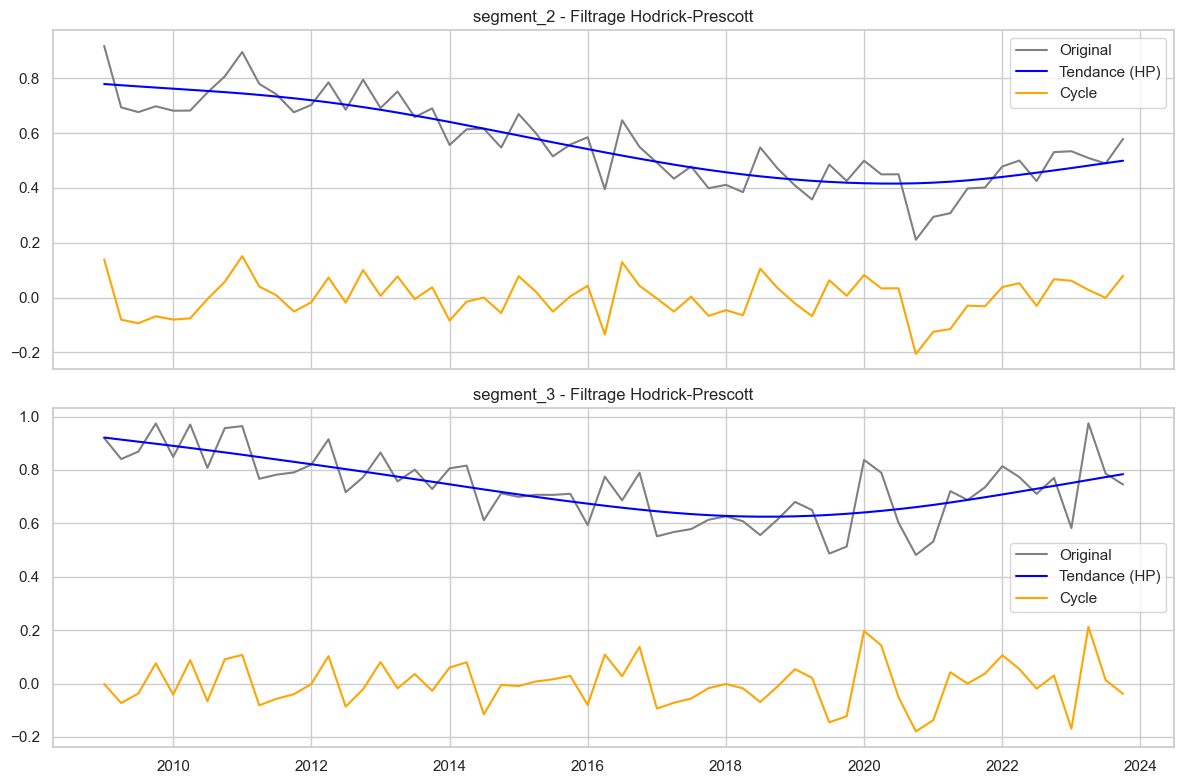

In [539]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Appliquer le filtre HP à chaque série non stationnaire
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, name in enumerate(["segment_2", "segment_3"]):
    df = segments_dfs[name]
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df["trend"] = trend
    df["cycle"] = cycle

    # Tracer
    axes[i].plot(df["date"], df["Indicateur_moyen_Brut"], label="Original", color='gray')
    axes[i].plot(df["date"], df["trend"], label="Tendance (HP)", color='blue')
    axes[i].plot(df["date"], df["cycle"], label="Cycle", color='orange')
    axes[i].set_title(f"{name} - Filtrage Hodrick-Prescott")
    axes[i].legend()

plt.tight_layout()
plt.show()


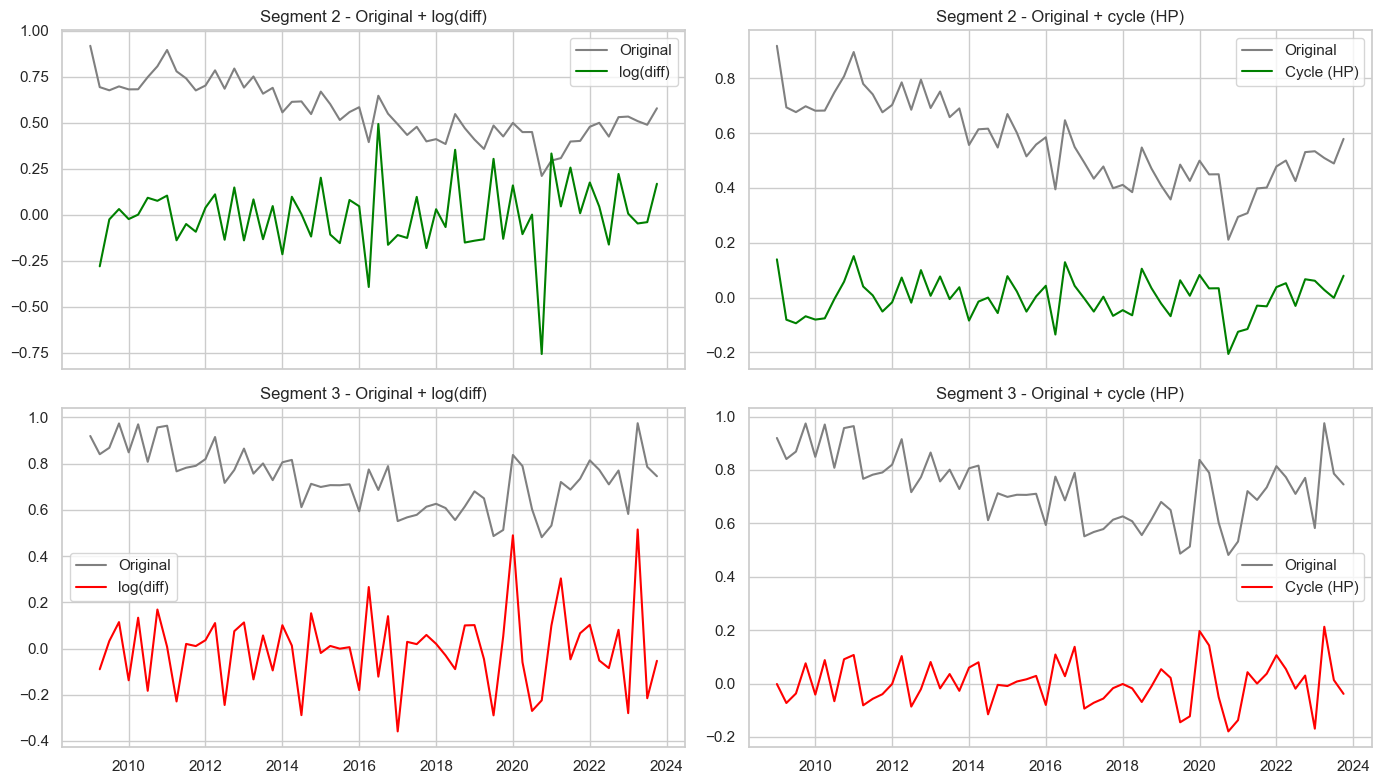

In [540]:
# Recalculer les séries stationnarisées par log.diff() pour segment_2 et segment_3
logdiff_dfs = {}
hp_cycle_dfs = {}

for name in ["segment_2", "segment_3"]:
    df = segments_dfs[name].copy()

    # Méthode log.diff()
    df_logdiff = df[["date", "Indicateur_moyen_Brut"]].copy()
    df_logdiff["log_diff"] = np.log(df_logdiff["Indicateur_moyen_Brut"]).diff()
    logdiff_dfs[name] = df_logdiff.dropna().reset_index(drop=True)

    # Méthode HP filter
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df_hp = df[["date"]].copy()
    df_hp["cycle"] = cycle
    hp_cycle_dfs[name] = df_hp.reset_index(drop=True)

# Ajouter les séries originales à côté des séries stationnarisées pour comparaison visuelle

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Segment 2
axes[0, 0].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 0].plot(logdiff_dfs["segment_2"]["date"], logdiff_dfs["segment_2"]["log_diff"], label="log(diff)", color="green")
axes[0, 0].set_title("Segment 2 - Original + log(diff)")
axes[0, 0].legend()

axes[0, 1].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 1].plot(hp_cycle_dfs["segment_2"]["date"], hp_cycle_dfs["segment_2"]["cycle"], label="Cycle (HP)", color="green")
axes[0, 1].set_title("Segment 2 - Original + cycle (HP)")
axes[0, 1].legend()

# Segment 3
axes[1, 0].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 0].plot(logdiff_dfs["segment_3"]["date"], logdiff_dfs["segment_3"]["log_diff"], label="log(diff)", color="red")
axes[1, 0].set_title("Segment 3 - Original + log(diff)")
axes[1, 0].legend()

axes[1, 1].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 1].plot(hp_cycle_dfs["segment_3"]["date"], hp_cycle_dfs["segment_3"]["cycle"], label="Cycle (HP)", color="red")
axes[1, 1].set_title("Segment 3 - Original + cycle (HP)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()



| Segment   | Meilleure méthode                                           |
| --------- | ----------------------------------------------------------- |
| Segment 2 | **HP filter** ✅ (plus régulier, moins bruité)               |
| Segment 3 | **log(diff)** ✅ (meilleure réactivité, structure conservée) |


#### Rechecker la stationnarité :

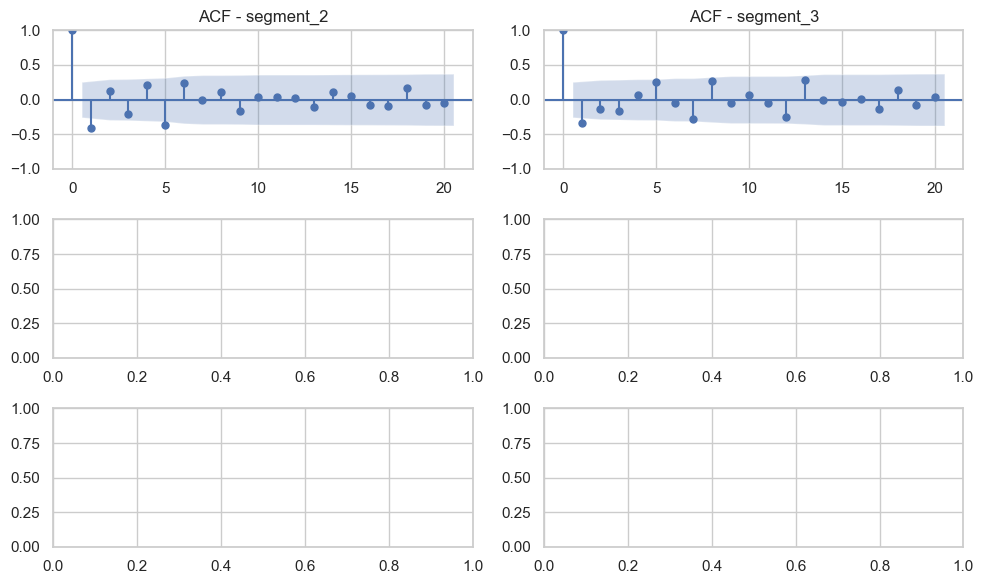

,Segment,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,segment_1,-3.983272,1.500683e-03,-3.546395,-2.911939,-2.593652
1,segment_4,-5.324879,4.861952e-06,-3.546395,-2.911939,-2.593652
2,segment_5,-4.430622,2.619040e-04,-3.546395,-2.911939,-2.593652
3,segment_6,NaN,NaN,NaN,NaN,NaN
4,segment_2,-5.251563,6.893226e-06,-3.557709,-2.916770,-2.596222
5,segment_3,-6.893328,1.338262e-09,-3.550670,-2.913766,-2.594624


In [541]:
# Recharger les bibliothèques nécessaires
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Préparer les séries finales pour ADF et ACF :
# segment_1, segment_4, segment_5, segment_6 → brut
# segment_2 → logdiff
# segment_3 → HP cycle
series_finales = {}

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
#series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()

# Segment 3 → log diff
series_finales["segment_3"] = logdiff_dfs["segment_3"]["log_diff"].dropna()


# Calculer ADF et tracer ACF
adf_results = []
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
axes = axes.flatten()

for i, (name, serie) in enumerate(series_finales.items()):
    # ADF test
    try:
        adf = adfuller(serie)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

    # Plot ACF
    plot_acf(serie, ax=axes[i], lags=20, alpha=0.05)
    axes[i].set_title(f"ACF - {name}")

plt.tight_layout()
plt.show()

display(df_adf_summary)

# Visualisation série après formatage : 

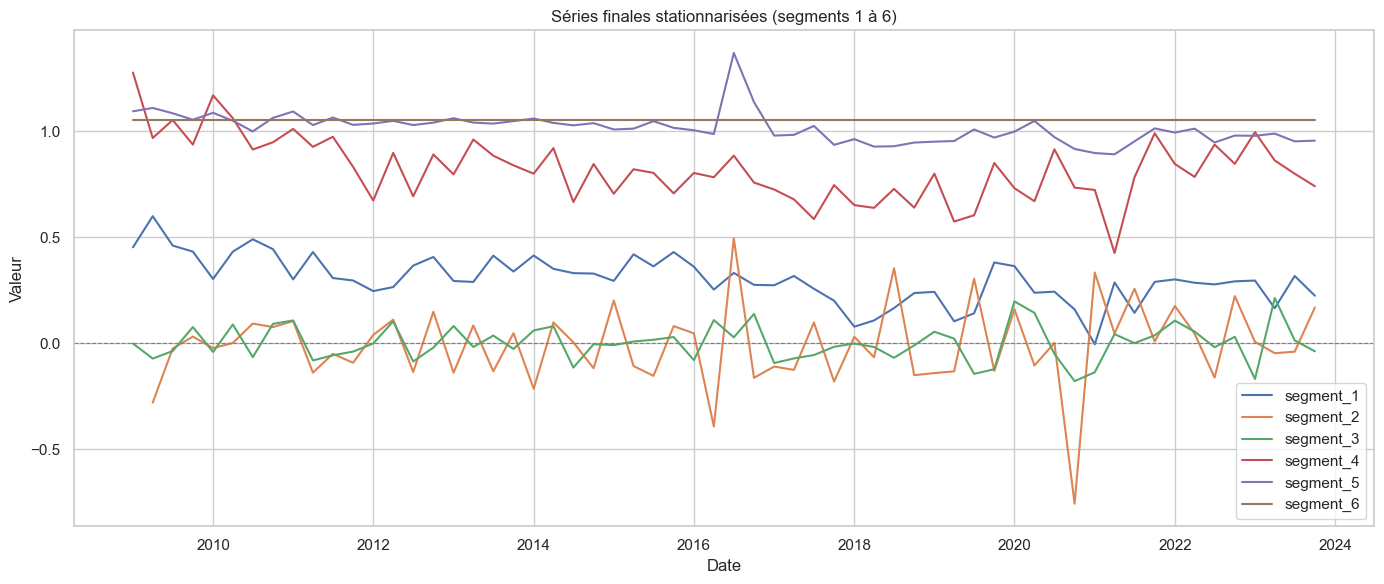

In [542]:
# Recréer les transformations nécessaires pour segment_2 (log diff) et segment_3 (HP cycle)
from statsmodels.tsa.filters.hp_filter import hpfilter

# Log diff pour segment_2
segment_2 = segments_dfs["segment_2"].copy()
logdiff_dfs = {
    "segment_2": segment_2[["date", "Indicateur_moyen_Brut"]].copy()
}
logdiff_dfs["segment_2"]["log_diff"] = np.log(logdiff_dfs["segment_2"]["Indicateur_moyen_Brut"]).diff()

# HP cycle pour segment_3
segment_3 = segments_dfs["segment_3"].copy()
cycle, trend = hpfilter(segment_3["Indicateur_moyen_Brut"], lamb=1600)
hp_cycle_dfs = {
    "segment_3": pd.DataFrame({
        "date": segment_3["date"],
        "cycle": cycle
    })
}

# Recréer series_finales à partir des segments disponibles
series_finales = {
    "segment_1": segments_dfs["segment_1"][["date", "Indicateur_moyen_Brut"]],
    "segment_2": logdiff_dfs["segment_2"][["date", "log_diff"]].rename(columns={"log_diff": "Indicateur_moyen_Brut"}).dropna(),
    "segment_3": hp_cycle_dfs["segment_3"][["date", "cycle"]].rename(columns={"cycle": "Indicateur_moyen_Brut"}),
    "segment_4": segments_dfs["segment_4"][["date", "Indicateur_moyen_Brut"]],
    "segment_5": segments_dfs["segment_5"][["date", "Indicateur_moyen_Brut"]],
    "segment_6": segments_dfs["segment_6"][["date", "Indicateur_moyen_Brut"]],
}

# Tracer toutes les séries sur une même grille
plt.figure(figsize=(14, 6))
for name, df in series_finales.items():
    plt.plot(df["date"], df["Indicateur_moyen_Brut"], label=name)

plt.title("Séries finales stationnarisées (segments 1 à 6)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


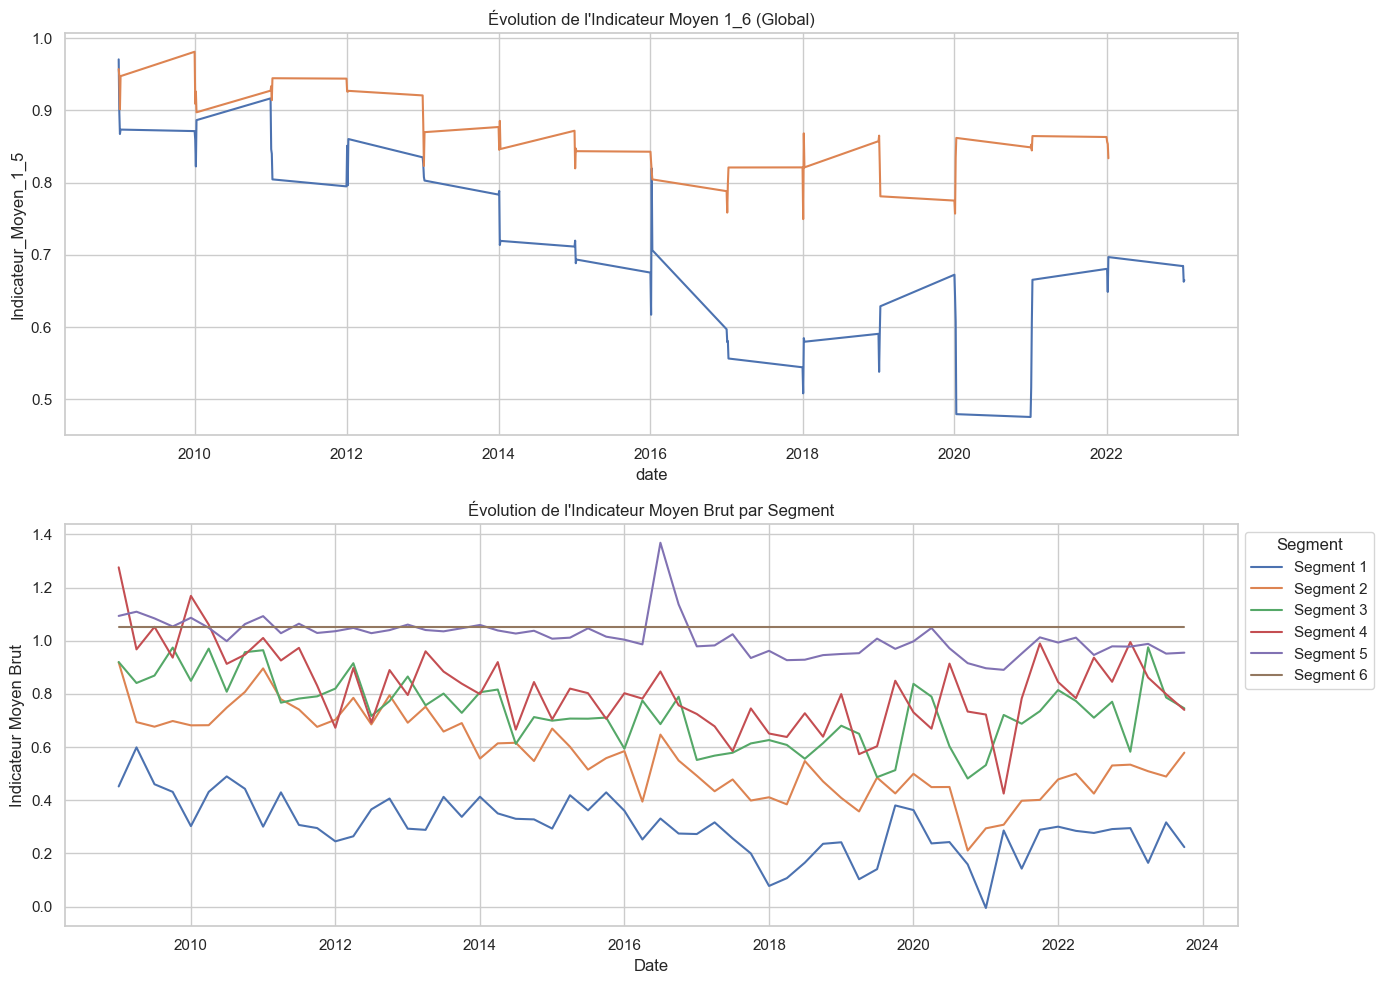

In [543]:
# Segments avec données brutes
for seg in ["segment_1", "segment_4", "segment_5", "segment_6"]:
    if seg in segments_dfs:
        series_finales[seg] = segments_dfs[seg]["Indicateur_moyen_Brut"].dropna()

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()


# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



## ANALYSE DES SERIES 

In [544]:
df_merged.drop(columns=["Indicateur_moyen_Brut_6"], inplace=True)

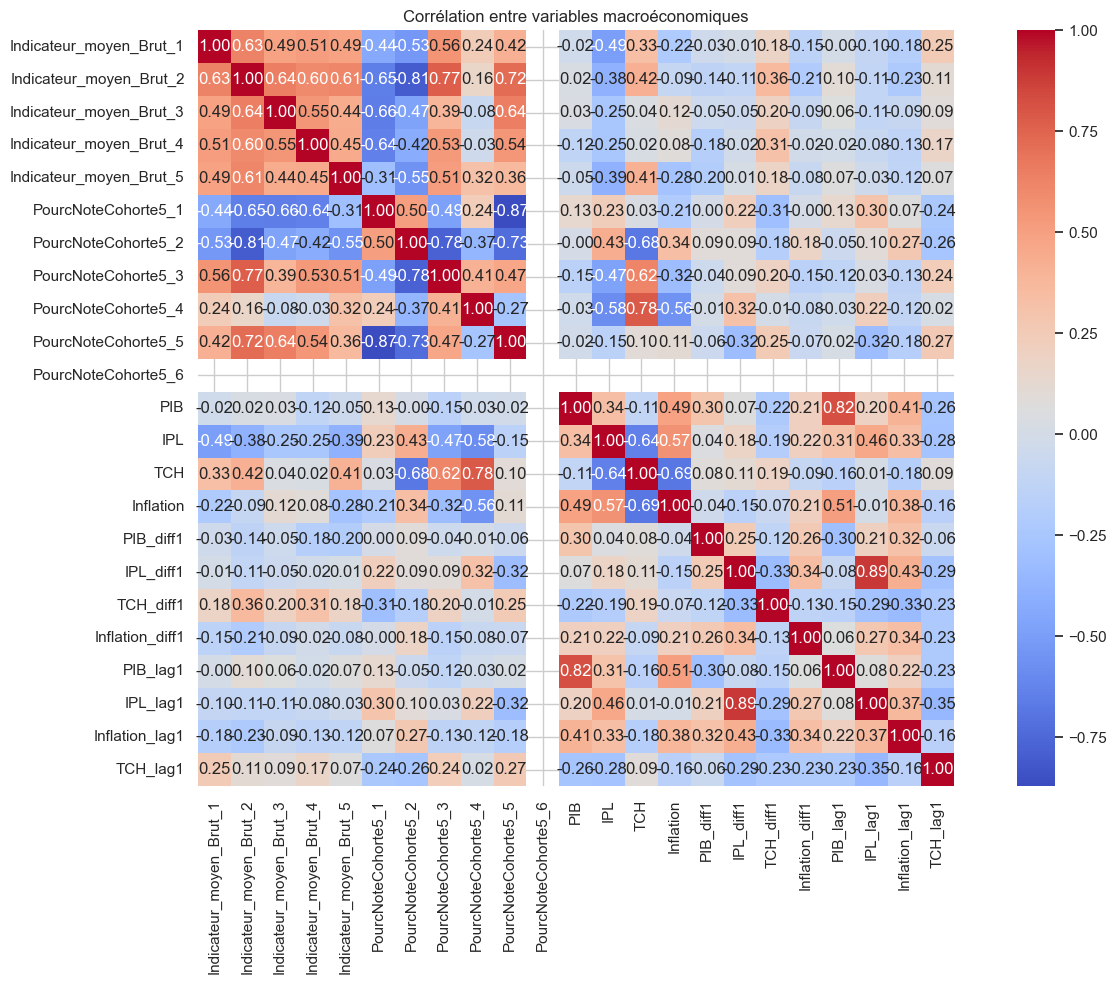

In [545]:
# Calcul de la matrice de corrélation complète
correlation_matrix = df_merged.corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()

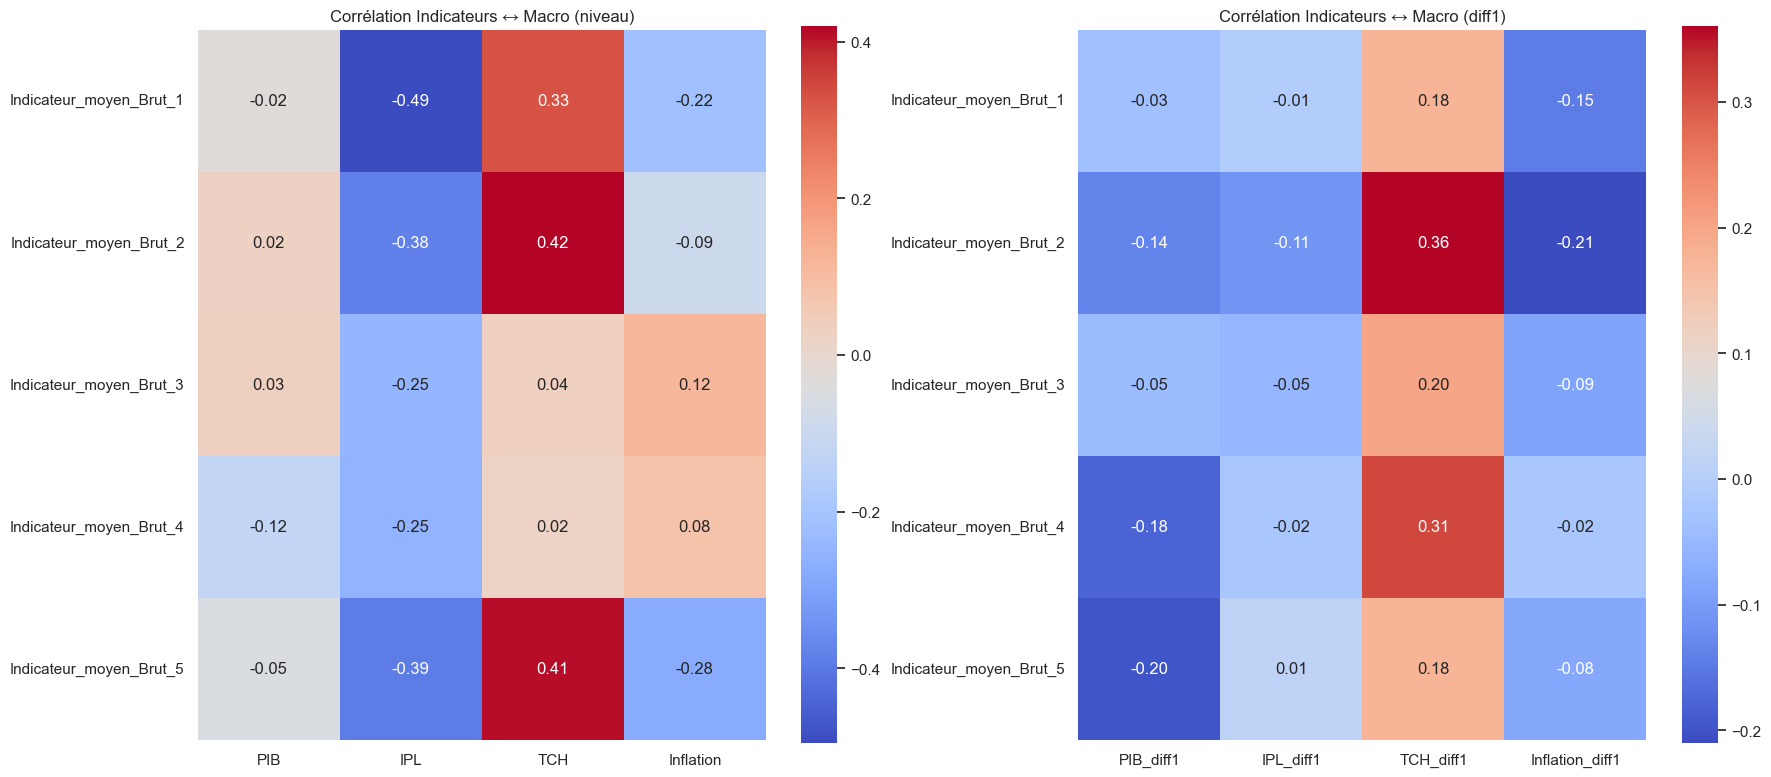

In [546]:
# Sélectionner uniquement les colonnes "Indicateur" et variables macro (niveau + diff1)
cols_indicateur = [col for col in df_merged.columns if col.startswith("Indicateur")]
cols_macro = ["PIB", "IPL", "TCH", "Inflation"]
cols_macro_diff = ["PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1"]

# Corrélation entre Indicateurs et valeurs macro
correlation_macro = df_merged[cols_indicateur + cols_macro].corr().loc[cols_indicateur, cols_macro]

# Corrélation entre Indicateurs et variations macro (diff1)
correlation_macro_diff = df_merged[cols_indicateur + cols_macro_diff].corr().loc[cols_indicateur, cols_macro_diff]

# Tracer les deux heatmaps sur des subplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Corrélation macro niveau
sns.heatmap(correlation_macro, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[0])
axes[0].set_title("Corrélation Indicateurs ↔ Macro (niveau)")

# Corrélation macro variations (diff1)
sns.heatmap(correlation_macro_diff, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[1])
axes[1].set_title("Corrélation Indicateurs ↔ Macro (diff1)")

plt.tight_layout()
plt.show()


# Modelisation


### TEST DES HYPOTHESES DU MCO :

In [547]:
df = df_merged.copy()

print(df.head())

print(df.info())

            Indicateur_moyen_Brut_1  Indicateur_moyen_Brut_2  \
date                                                           
2009-01-01                 0.451963                 0.918515   
2009-04-01                 0.598795                 0.693970   
2009-07-01                 0.460212                 0.676645   
2009-10-01                 0.431518                 0.697949   
2010-01-01                 0.302710                 0.681718   

            Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
date                                                           
2009-01-01                 0.919843                 1.275864   
2009-04-01                 0.840965                 0.967390   
2009-07-01                 0.868909                 1.052081   
2009-10-01                 0.974173                 0.936315   
2010-01-01                 0.849149                 1.168515   

            Indicateur_moyen_Brut_5  PourcNoteCohorte5_1  PourcNoteCohorte5_2  \
date                 

| Hypothèse                                                | Objectif                                                                            | Comment tester ?                                           | Graphique utile ?                     | Test statistique                  |
| -------------------------------------------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------- | ------------------------------------- | --------------------------------- |
| **1. Linéarité**                                         | La relation entre Y et X est linéaire                                               | - Résidus vs prédictions : doit être aléatoire, sans motif | ✅ OUI (essentiel)                     | Pas nécessaire                    |
| **2. Indépendance des erreurs**                          | Les erreurs ne doivent pas être autocorrélées                                       | - ACF des résidus<br>- Test de Durbin-Watson ≈ 2           | ✅ OUI (utile)                         | ✅ Durbin-Watson                   |
| **3. Homoscédasticité** (variance constante des erreurs) | Pas de structure dans la variance des erreurs                                       | - Résidus vs prédictions : doit être horizontal            | ✅ OUI (essentiel)                     | ✅ Breusch-Pagan                   |
| **4. Normalité des résidus**                             | Les résidus doivent être normalement distribués pour valider les tests statistiques | - Histogramme avec KDE<br>- QQ-plot                        | ✅ OUI (utile)                         | ✅ Shapiro-Wilk<br>✅ Jarque-Bera   |
| **5. Non-colinéarité entre les X**                       | Les variables explicatives ne doivent pas être trop corrélées entre elles           | - Matrice de corrélation<br>- Calcul des VIF               | 🚫 (pas un graphique sur les résidus) | ✅ VIF (Variance Inflation Factor) |


,Segment,R²,Adj. R²,AIC,BIC,F-statistic,F p-val,Durbin-Watson,const p-val,PIB p-val,IPL p-val,Inflation p-val,TCH_diff1 p-val
0,Indicateur_moyen_Brut_1,0.2563,0.1396,-97.3715,-78.5224,2.1969,0.0430,1.1949,0.0,0.2486,None,None,0.0150
1,Indicateur_moyen_Brut_2,0.2987,0.1887,-61.5021,-42.6530,2.7153,0.0143,0.7399,0.0,0.5040,None,None,0.0011
2,Indicateur_moyen_Brut_3,0.1495,0.0160,-69.1242,-50.2751,1.1202,0.3658,1.2379,0.0,0.5472,None,None,0.0225
3,Indicateur_moyen_Brut_4,0.2691,0.1544,-62.2390,-43.3899,2.3467,0.0313,1.5454,0.0,0.5018,None,None,0.0008
4,Indicateur_moyen_Brut_5,0.1610,0.0294,-146.2296,-127.3805,1.2234,0.3047,1.3172,0.0,0.4540,None,None,0.0445


,Segment,Durbin-Watson,DW Interprétation,Shapiro p-val,Shapiro Interprétation,Jarque-Bera p-val,JB Interprétation
0,Indicateur_moyen_Brut_1,1.195,Autocorrélation,0.203,Normaux,0.504,Normaux
1,Indicateur_moyen_Brut_2,0.740,Autocorrélation,0.930,Normaux,0.930,Normaux
2,Indicateur_moyen_Brut_3,1.238,Autocorrélation,0.606,Normaux,0.883,Normaux
3,Indicateur_moyen_Brut_4,1.545,OK,0.336,Normaux,0.477,Normaux
4,Indicateur_moyen_Brut_5,1.317,Autocorrélation,0.000,Non normaux,0.000,Non normaux


,Segment,Variable,VIF,Colinéarité
0,Indicateur_moyen_Brut_1,const,1.17,OK
1,Indicateur_moyen_Brut_1,PIB,3.96,OK
2,Indicateur_moyen_Brut_1,IPL_diff1,6.99,Élevée
3,Indicateur_moyen_Brut_1,Inflation_diff1,1.27,OK
4,Indicateur_moyen_Brut_1,TCH_diff1,1.50,OK
5,Indicateur_moyen_Brut_1,PIB_lag1,3.51,OK
6,Indicateur_moyen_Brut_1,IPL_lag1,6.06,Élevée
7,Indicateur_moyen_Brut_1,Inflation_lag1,1.62,OK
8,Indicateur_moyen_Brut_1,TCH_lag1,1.51,OK
9,Indicateur_moyen_Brut_2,const,1.17,OK


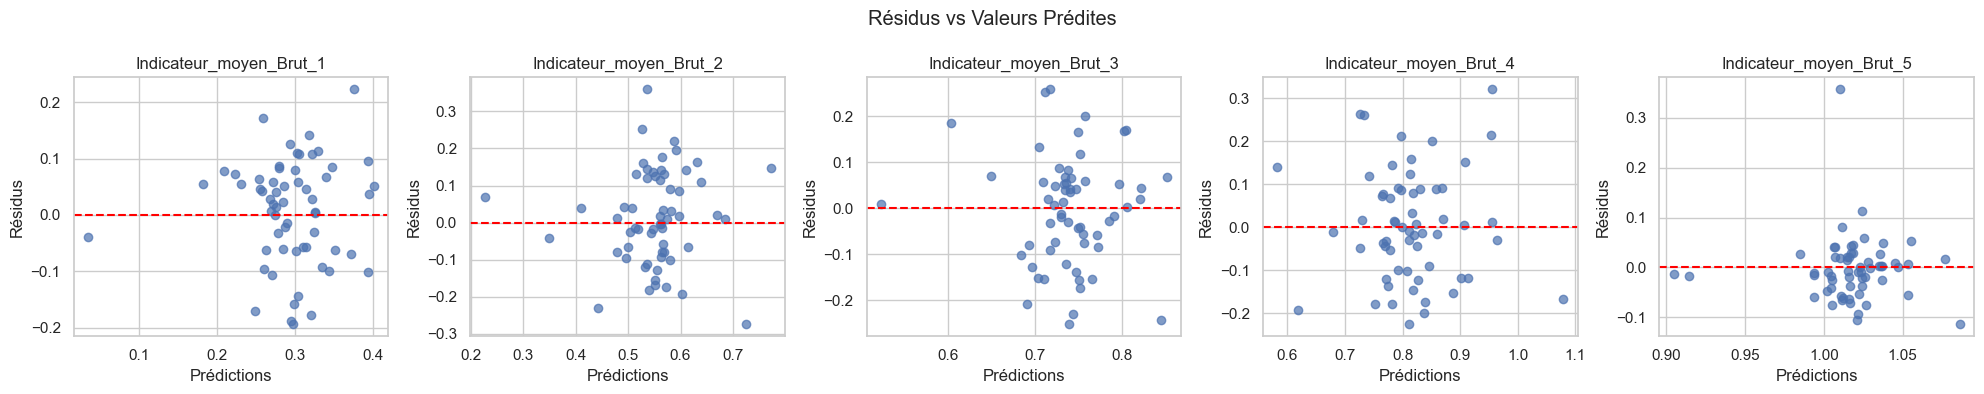

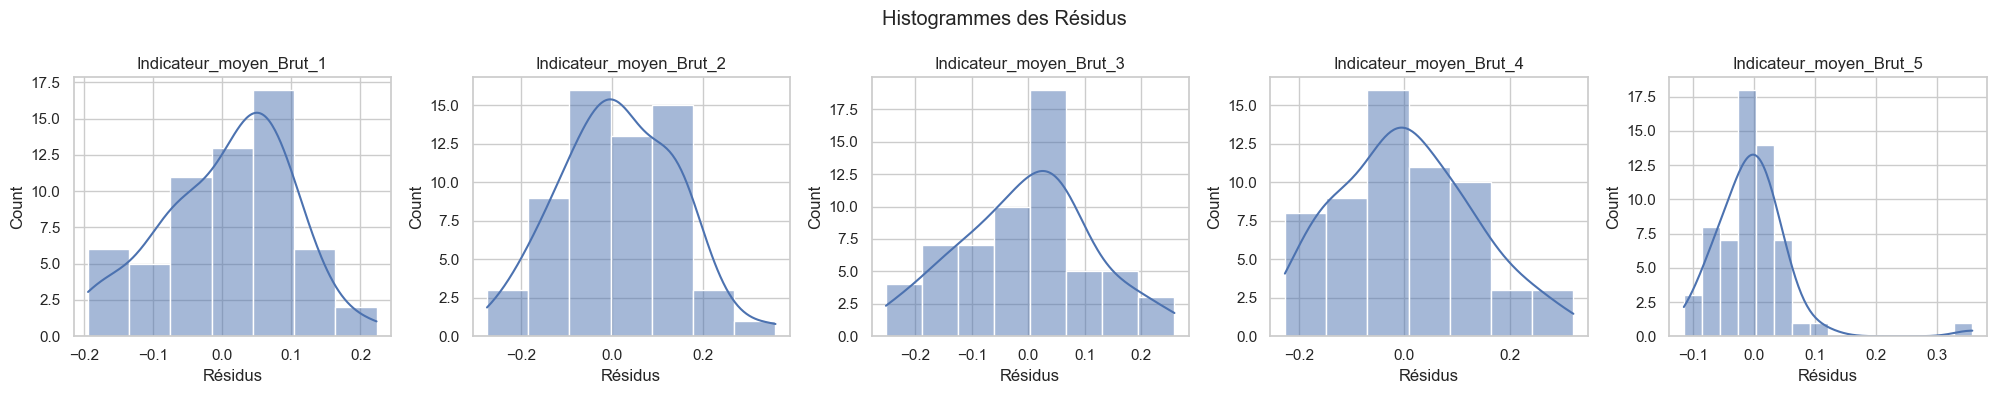

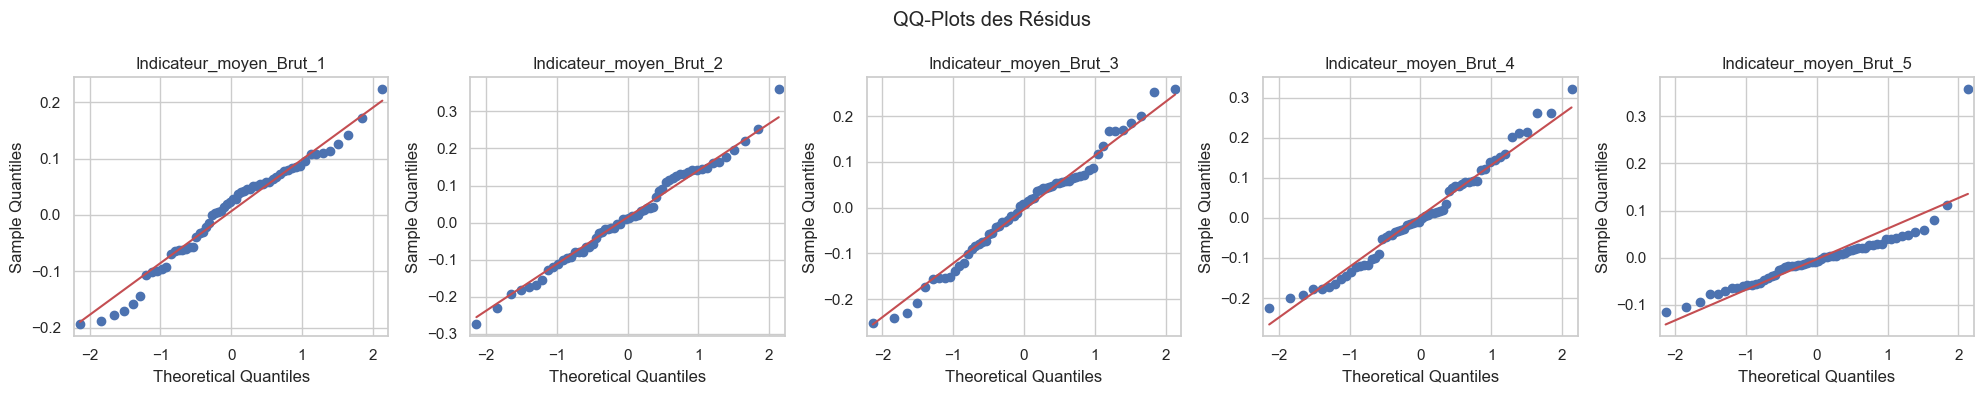

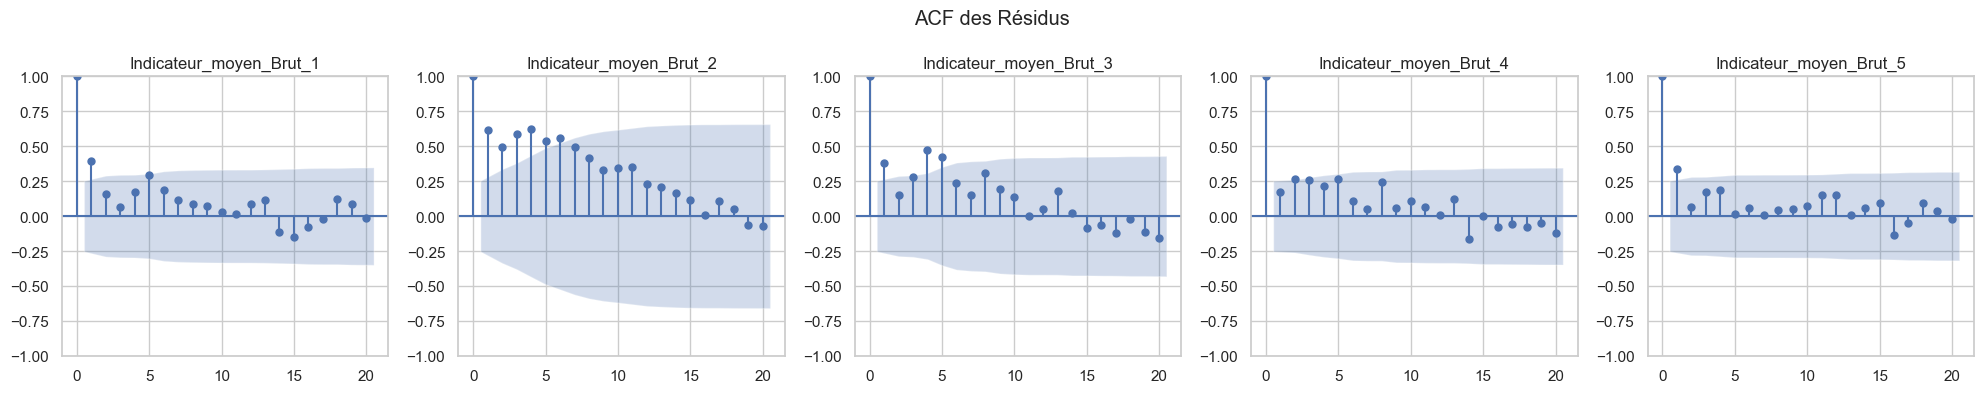

In [564]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Paramètres ===
macro_vars = ['PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1', 'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1']

segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2',
    'Indicateur_moyen_Brut_3',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Après avoir généré toutes les colonnes dérivées
df = df.dropna(subset=macro_vars + segments).copy()


residuals_dict = {}
fitted_dict = {}

# Conteneur des résultats
summary_list = []

models = []

# Initialiser les tableaux de résultats
tests_summary = []
vif_summary = []

# === Étape 1 : entraînement des modèles et stockage des résidus ===
for seg in segments:
    segment_num = seg.split('_')[-1]  # extrait le numéro : '1', '2', ...
    weight_col = f"PourcNoteCohorte5_{segment_num}"
    
    # Garder uniquement les lignes valides
    data = df[macro_vars + [seg, weight_col]].dropna()
    
    y = data[seg]
    X = sm.add_constant(data[macro_vars])
    weights = data[weight_col]
    
    # Régression pondérée
    model = sm.WLS(y, X, weights=weights).fit()

    models.append(model)

    #model = sm.OLS(y, X).fit()
    residuals_dict[seg] = model.resid
    fitted_dict[seg] = model.fittedvalues

    residuals = model.resid
    fitted = model.fittedvalues

    # Récupération des valeurs clés
    summary_list.append({
        "Segment": seg,
        "R²": model.rsquared,
        "Adj. R²": model.rsquared_adj,
        "AIC": model.aic,
        "BIC": model.bic,
        "F-statistic": model.fvalue,
        "F p-val": model.f_pvalue,
        "Durbin-Watson": durbin_watson(model.resid),
        "const p-val": model.pvalues['const'],
        "PIB p-val": model.pvalues.get('PIB', None),
        "IPL p-val": model.pvalues.get('IPL', None),
        "Inflation p-val": model.pvalues.get('Inflation', None),
        "TCH_diff1 p-val": model.pvalues.get('TCH_diff1', None),
    })

    # --- Tests statistiques ---
    dw = durbin_watson(residuals)
    shapiro_p = shapiro(residuals).pvalue
    jb_p = jarque_bera(residuals).pvalue
    #bp_p = het_breuschpagan(residuals, X)[1]

    # --- Interprétations simples ---
    dw_interp = "OK" if 1.5 < dw < 2.5 else "Autocorrélation"
    shapiro_interp = "Normaux" if shapiro_p > 0.05 else "Non normaux"
    jb_interp = "Normaux" if jb_p > 0.05 else "Non normaux"
    #bp_interp = "Homoscédasticité" if bp_p > 0.05 else "Hétéroscédasticité"

    tests_summary.append({
        "Segment": seg,
        "Durbin-Watson": round(float(dw), 3),
        "DW Interprétation": dw_interp,
        "Shapiro p-val": round(float(shapiro_p), 3),
        "Shapiro Interprétation": shapiro_interp,
        "Jarque-Bera p-val": round(float(jb_p), 3),
        "JB Interprétation": jb_interp,
        #"Breusch-Pagan p-val": round(float(bp_p), 3),
        #"BP Interprétation": bp_interp
    })

    # --- VIF ---
    vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for var, vif in zip(X.columns, vif_values):
        vif_summary.append({
            "Segment": seg,
            "Variable": var,
            "VIF": round(vif, 2),
            "Colinéarité": "Élevée" if vif > 5 else "OK"
        })

# Création du DataFrame final
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.round(4)  # arrondi pour lisibilité

# Convertir en DataFrames
tests_df = pd.DataFrame(tests_summary)
vif_df = pd.DataFrame(vif_summary)


display(summary_df)
display(tests_df)
display(vif_df)


# === Étape 2 : Résidus vs Valeurs prédites ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    axs[i].scatter(fitted_dict[seg], residuals_dict[seg], alpha=0.7)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(seg)
    axs[i].set_xlabel("Prédictions")
    axs[i].set_ylabel("Résidus")
fig.suptitle("Résidus vs Valeurs Prédites")
plt.tight_layout()
plt.show()

# === Étape 3 : Histogramme des résidus ===
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, seg in enumerate(segments):
    sns.histplot(residuals_dict[seg], kde=True, ax=axs[i])
    axs[i].set_title(seg)
    axs[i].set_xlabel("Résidus")
fig.suptitle("Histogrammes des Résidus")
plt.tight_layout()
plt.show()

# === Étape 4 : QQ-Plot des résidus ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    sm.qqplot(residuals_dict[seg], line='s', ax=ax)
    ax.set_title(seg)
fig.suptitle("QQ-Plots des Résidus")
plt.tight_layout()
plt.show()

# === Étape 5 : ACF des résidus ===
fig = plt.figure(figsize=(20, 4))
for i, seg in enumerate(segments):
    ax = fig.add_subplot(1, 5, i+1)
    max_lags = min(20, len(residuals_dict[seg]) - 1)
    sm.graphics.tsa.plot_acf(residuals_dict[seg], lags=max_lags, ax=ax)
    ax.set_title(seg)
fig.suptitle("ACF des Résidus")
plt.tight_layout()
plt.show()


### Modélisation : 

In [550]:
df.head()

,Indicateur_moyen_Brut_1,Indicateur_moyen_Brut_2,Indicateur_moyen_Brut_3,Indicateur_moyen_Brut_4,Indicateur_moyen_Brut_5,PourcNoteCohorte5_1,PourcNoteCohorte5_2,PourcNoteCohorte5_3,PourcNoteCohorte5_4,PourcNoteCohorte5_5,...,TCH,Inflation,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,PIB_lag1,IPL_lag1,Inflation_lag1,TCH_lag1
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0.451963,0.918515,0.919843,1.275864,1.093203,0.115244,0.237795,0.130521,0.084689,0.431750,...,8.3,0.301692,-1.430885,-2.593841,0.9,-0.697982,0.144097,-2.204378,-1.979658,0.3
2009-04-01,0.598795,0.693970,0.840965,0.967390,1.109015,0.109356,0.254647,0.131660,0.101921,0.402416,...,8.8,-0.489570,-0.956314,-2.654313,0.5,-0.791262,-1.286788,-2.593841,-0.697982,0.9
2009-07-01,0.460212,0.676645,0.868909,1.052081,1.083922,0.100492,0.295740,0.142272,0.091207,0.370289,...,8.8,-0.362976,-0.769164,-1.824787,0.0,0.126594,-2.243102,-2.654313,-0.791262,0.5
2009-10-01,0.431518,0.697949,0.974173,0.936315,1.053459,0.102461,0.265383,0.130819,0.098983,0.402354,...,9.2,0.914470,0.229433,-0.001851,0.4,1.277447,-3.012266,-1.824787,0.126594,0.0
2010-01-01,0.302710,0.681718,0.849149,1.168515,1.086222,0.109683,0.255927,0.143388,0.103970,0.387032,...,9.0,1.589859,1.265167,1.827158,-0.2,0.675389,-2.782833,-0.001851,1.277447,0.4


In [573]:
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year
df['quarter'] = df.index.quarter

macro_vars = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1'
]

segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2',
    'Indicateur_moyen_Brut_3',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Supprimer les lignes incomplètes
df_model = df.dropna(subset=segments + macro_vars).copy()

import statsmodels.api as sm

models = {}

for segment in segments:
    X = df_model[macro_vars]
    X = sm.add_constant(X)  # ajouter constante
    y = df_model[segment]

    model = sm.OLS(y, X).fit()
    models[segment] = model

    print(f"Modèle pour {segment} — R² : {round(model.rsquared, 4)}")

forecast_list = []

for quarter in range(1, 5):
    # Données macro Tn 2024
    row = df_model[(df_model['year'] == 2023) & (df_model['quarter'] == quarter)]

    if row.empty:
        continue

    x_input = row[macro_vars].values[0]
    x_input_with_const = np.append([1], x_input)
    x_input = np.tile(x_input_with_const, (3, 1))  # répéter pour 3 années

    #x_input = sm.add_constant(x_input)

    for segment in segments:
        model = models[segment]
        preds = model.predict(x_input)

        for i, year in enumerate([2025, 2026, 2027]):
            forecast_list.append({
                'Segment': segment,
                'Trimestre': f"T{quarter}",
                'Année': year,
                'Prévision': preds[i]
            })

forecast_df = pd.DataFrame(forecast_list)

print(forecast_df)


Modèle pour Indicateur_moyen_Brut_1 — R² : 0.288
Modèle pour Indicateur_moyen_Brut_2 — R² : 0.3015
Modèle pour Indicateur_moyen_Brut_3 — R² : 0.1318
Modèle pour Indicateur_moyen_Brut_4 — R² : 0.2721
Modèle pour Indicateur_moyen_Brut_5 — R² : 0.1419
                    Segment Trimestre  Année  Prévision
0   Indicateur_moyen_Brut_1        T1   2025   0.226855
1   Indicateur_moyen_Brut_1        T1   2026   0.226855
2   Indicateur_moyen_Brut_1        T1   2027   0.226855
3   Indicateur_moyen_Brut_2        T1   2025   0.503446
4   Indicateur_moyen_Brut_2        T1   2026   0.503446
5   Indicateur_moyen_Brut_2        T1   2027   0.503446
6   Indicateur_moyen_Brut_3        T1   2025   0.690676
7   Indicateur_moyen_Brut_3        T1   2026   0.690676
8   Indicateur_moyen_Brut_3        T1   2027   0.690676
9   Indicateur_moyen_Brut_4        T1   2025   0.744098
10  Indicateur_moyen_Brut_4        T1   2026   0.744098
11  Indicateur_moyen_Brut_4        T1   2027   0.744098
12  Indicateur_moyen_Br

In [579]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Initialisation
segments = [f'Indicateur_moyen_Brut_{i}' for i in range(1, 6)]
macro_vars = [
    'PIB', 'IPL_diff1', 'Inflation_diff1', 'TCH_diff1',
    'PIB_lag1', 'IPL_lag1', 'Inflation_lag1', 'TCH_lag1'
]

# Assure l'index
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year
df['quarter'] = df.index.quarter

# Étape 1 — entraînement des modèles jusqu'à fin 2023
df_train = df[df['year'] <= 2023].dropna(subset=segments + macro_vars)
models = {}

for segment in segments:
    X = sm.add_constant(df_train[macro_vars])
    y = df_train[segment]
    model = sm.OLS(y, X).fit()
    models[segment] = model
    print(f"{segment} — R² : {round(model.rsquared, 4)}")

# Étape 2 — boucle récursive sur 2024, 2025, 2026, 2027
df_forecast = df.copy()
results = []

for year in [2024, 2025, 2026, 2027]:
    for quarter in [1, 2, 3, 4]:
        print(df[df['year'] >= 2024][macro_vars].dropna())

        # Cherche les features macro dispo pour l’année en cours
        row = df_forecast[(df_forecast['year'] == year) & (df_forecast['quarter'] == quarter)]
        if row.empty:
            continue

        # Construction du vecteur X
        x_input = row[macro_vars].values[0]
        x_input = sm.add_constant(x_input.reshape(1, -1))

        for segment in segments:
            model = models[segment]
            y_pred = model.predict(x_input)[0]

            # Ajout de la prédiction dans le dataframe source
            df_forecast.loc[row.index, segment] = y_pred

            results.append({
                'Année': year,
                'Trimestre': f"T{quarter}",
                'Segment': segment,
                'Prévision': y_pred
            })

    # Après chaque année, mettre à jour les variables "_lag1"
    df_forecast['PIB_lag1'] = df_forecast['PIB'].shift(1)
    df_forecast['IPL_lag1'] = df_forecast['IPL_diff1'].shift(1)
    df_forecast['Inflation_lag1'] = df_forecast['Inflation_diff1'].shift(1)
    df_forecast['TCH_lag1'] = df_forecast['TCH_diff1'].shift(1)

# Résultats finaux
forecast_df = pd.DataFrame(results)
print(forecast_df)


Indicateur_moyen_Brut_1 — R² : 0.288
Indicateur_moyen_Brut_2 — R² : 0.3015
Indicateur_moyen_Brut_3 — R² : 0.1318
Indicateur_moyen_Brut_4 — R² : 0.2721
Indicateur_moyen_Brut_5 — R² : 0.1419
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_diff1, TCH_diff1, PIB_lag1, IPL_lag1, Inflation_lag1, TCH_lag1]
Index: []
Empty DataFrame
Columns: [PIB, IPL_diff1, Inflation_dif

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Variables macro utilisées comme prédicteurs
macro_vars = ['PIB_diff1', 'IPL_diff1', 'TCH_diff1', 'Inflation_diff1', 'PIB_lag1', 'IPL_lag1', 'TCH_lag1', 'Inflation_lag1']

# Segments à prédire
segments = [
    'Indicateur_moyen_Brut_1',
    'Indicateur_moyen_Brut_2',
    'Indicateur_moyen_Brut_3',
    'Indicateur_moyen_Brut_4',
    'Indicateur_moyen_Brut_5'
]

# Résultats à stocker
results = []

# Régression OLS pour chaque segment
for target in segments:
    data = df.dropna(subset=macro_vars + [target])
    X = sm.add_constant(data[macro_vars])
    y = data[target]
    
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    results.append({
        "Segment": target,
        "R2_score": round(r2, 4),
        "Coefficients": model.params.to_dict()
    })

# Transformation en DataFrame pour affichage
results_df = pd.DataFrame(results)

results_df.head()


,Segment,R2_score,Coefficients
0,Indicateur_moyen_Brut_1,0.2880,"{'const': 0.2905378991075388, 'PIB_diff1': 0.0..."
1,Indicateur_moyen_Brut_2,0.3015,"{'const': 0.5506194208097404, 'PIB_diff1': 0.0..."
2,Indicateur_moyen_Brut_3,0.1318,"{'const': 0.7242108919040903, 'PIB_diff1': 0.0..."
3,Indicateur_moyen_Brut_4,0.2721,"{'const': 0.8099720198637482, 'PIB_diff1': -0...."
4,Indicateur_moyen_Brut_5,0.1419,"{'const': 1.0103343346455034, 'PIB_diff1': -0...."


## Scénarios :

📅 Prévisions à 3 ans depuis T1 2024 – **Horizon T1 2025 / 2026 / 2027**

| Scénario | Année | PIB  | IPL | TCH  | Inflation |
| -------- | ----- | ---- | --- | ---- | --------- |
| REEL     | 2023  | 1.10 | -2  | 7.5  | 2.4       |
| PESS     | 2024  | -0.6 | -3  | 7.97 | 7.0       |
| CENT     | 2024  | 0.4  | 1   | 7.62 | 1.7       |
| OPTI     | 2024  | 1.5  | 3   | 7.2  | 0.0       |
| PESS     | 2025  | 0.25 | -5  | 8.24 | 5.0       |
| CENT     | 2025  | 0.95 | 2   | 7.7  | 1.78      |
| OPTI     | 2025  | 1.78 | 5   | 6.7  | 0.65      |
| PESS     | 2026  | 1.2  | -7  | 8.4  | 2.0       |
| CENT     | 2026  | 1.34 | 2   | 7.8  | 1.84      |
| OPTI     | 2026  | 1.6  | 7   | 7.0  | 2.1       |

---

 📅 Horizon T2 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | -0.387 | -3.5 | 8.0375 | 6.5       |
| CENT     | 2024  | 0.5375 | 1.25 | 7.64   | 1.72      |
| OPTI     | 2024  | 1.57   | 3.5  | 7.075  | 0.1625    |
| PESS     | 2025  | 0.4875 | -5.5 | 8.28   | 4.25      |
| CENT     | 2025  | 1.0475 | 2    | 7.725  | 1.795     |
| OPTI     | 2025  | 1.735  | 5.5  | 6.775  | 1.0125    |
| PESS     | 2026  | 1.225  | -6   | 8.3    | 1.975     |
| CENT     | 2026  | 1.355  | 1.75 | 7.725  | 1.88      |
| OPTI     | 2026  | 1.625  | 6    | 7.05   | 2.1       |

---

📅 Horizon T3 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL | TCH   | Inflation |
| -------- | ----- | ------ | --- | ----- | --------- |
| REEL     | 2023  | 1.10   | -2  | 7.5   | 2.4       |
| PESS     | 2024  | -0.175 | -4  | 8.105 | 6.0       |
| CENT     | 2024  | 0.675  | 1.5 | 7.66  | 1.74      |
| OPTI     | 2024  | 1.64   | 4   | 6.95  | 0.325     |
| PESS     | 2025  | 0.725  | -6  | 8.32  | 3.5       |
| CENT     | 2025  | 1.145  | 2   | 7.75  | 1.81      |
| OPTI     | 2025  | 1.69   | 6   | 6.85  | 1.375     |
| PESS     | 2026  | 1.25   | -5  | 8.2   | 1.95      |
| CENT     | 2026  | 1.37   | 1.5 | 7.65  | 1.92      |
| OPTI     | 2026  | 1.65   | 5   | 7.1   | 2.1       |

---

 📅 Horizon T4 2025 / 2026 / 2027

| Scénario | Année | PIB    | IPL  | TCH    | Inflation |
| -------- | ----- | ------ | ---- | ------ | --------- |
| REEL     | 2023  | 1.10   | -2   | 7.5    | 2.4       |
| PESS     | 2024  | 0.0375 | -4.5 | 8.1725 | 5.5       |
| CENT     | 2024  | 0.8125 | 1.75 | 7.68   | 1.76      |
| OPTI     | 2024  | 1.71   | 4.5  | 6.825  | 0.4875    |
| PESS     | 2025  | 0.9625 | -6.5 | 8.36   | 2.75      |
| CENT     | 2025  | 1.2425 | 2    | 7.775  | 1.825     |
| OPTI     | 2025  | 1.645  | 6.5  | 6.925  | 1.7375    |
| PESS     | 2026  | 1.275  | -4   | 8.1    | 1.925     |
| CENT     | 2026  | 1.385  | 1.25 | 7.575  | 1.96      |
| OPTI     | 2026  | 1.675  | 4    | 7.15   | 2.1       |

Verif PIB 2023 : 

In [585]:
# Filtrer les colonnes et les lignes pour l'année 2023
df_2023 = df.loc[df['year'] == 2023, ['PIB', 'IPL', 'TCH', 'Inflation']]

# Afficher le DataFrame filtré
print(df_2023)

                 PIB       IPL  TCH  Inflation
date                                          
2023-01-01  1.687226  5.190174  6.9   5.701873
2023-04-01  1.061365  3.664003  7.0   4.531319
2023-07-01  0.876149  1.650038  7.2   4.896221
2023-10-01  0.868858 -0.455149  7.3   3.705326


In [599]:
# Dernières valeurs macro observées en 2023
last_real = {"PIB": 1.10, "IPL": -2, "TCH": 7.5, "Inflation": 2.4}

# Scénarios économiques à horizon T1
scenarios = {
    "PESS": {
        2024: {"PIB": -0.6, "IPL": -3, "TCH": 7.97, "Inflation": 7.0},
        2025: {"PIB": 0.25, "IPL": -5, "TCH": 8.24, "Inflation": 5.0},
        2026: {"PIB": 1.2, "IPL": -7, "TCH": 8.4, "Inflation": 2.0}
    },
    "CENT": {
        2024: {"PIB": 0.4, "IPL": 1, "TCH": 7.62, "Inflation": 1.7},
        2025: {"PIB": 0.95, "IPL": 2, "TCH": 7.7, "Inflation": 1.78},
        2026: {"PIB": 1.34, "IPL": 2, "TCH": 7.8, "Inflation": 1.84}
    },
    "OPTI": {
        2024: {"PIB": 1.5, "IPL": 3, "TCH": 7.2, "Inflation": 0.0},
        2025: {"PIB": 1.78, "IPL": 5, "TCH": 6.7, "Inflation": 0.65},
        2026: {"PIB": 1.6, "IPL": 7, "TCH": 7.0, "Inflation": 2.1}
    }
}

# Lancer les projections
projection_rows = []

for _, row in results_df.iterrows():
    segment = row["Segment"]
    coefs = row["Coefficients"]
    
    for scenario, year_data in scenarios.items():
        prev = last_real.copy()
        for year, values in year_data.items():
            PIB_diff1 = values["PIB"] - prev["PIB"]
            IPL_diff1 = values["IPL"] - prev["IPL"]
            TCH_diff1 = values["TCH"] - prev["TCH"]
            Inflation_diff1 = values["Inflation"] - prev["Inflation"]

            PIB_lag1 = prev["PIB"]
            IPL_lag1 = prev["IPL"]
            TCH_lag1 = prev["TCH"]
            Inflation_lag1 = prev["Inflation"]

            # Prédiction à partir des coefficients
            y_pred = (
                coefs.get("const", 0)
                + coefs.get("PIB_diff1", 0) * PIB_diff1
                + coefs.get("IPL_diff1", 0) * IPL_diff1
                + coefs.get("TCH_diff1", 0) * TCH_diff1
                + coefs.get("Inflation_diff1", 0) * Inflation_diff1
                + coefs.get("PIB_lag1", 0) * PIB_lag1
                + coefs.get("IPL_lag1", 0) * IPL_lag1
                + coefs.get("TCH_lag1", 0) * TCH_lag1
                + coefs.get("Inflation_lag1", 0) * Inflation_lag1
            )

            projection_rows.append({
                "Segment": segment,
                "Scénario": scenario,
                "Année": year,
                "Prévision_CCF": round(y_pred, 4)
            })

            prev = values  # mise à jour pour l’année suivante

# DataFrame final des prévisions
projection_df = pd.DataFrame(projection_rows)

projection_df.head()


,Segment,Scénario,Année,Prévision_CCF
0,Indicateur_moyen_Brut_1,PESS,2024,1.0980
1,Indicateur_moyen_Brut_1,PESS,2025,1.0676
2,Indicateur_moyen_Brut_1,PESS,2026,1.3411
3,Indicateur_moyen_Brut_1,CENT,2024,1.5687
4,Indicateur_moyen_Brut_1,CENT,2025,1.2360


In [600]:
df.head()

,Indicateur_moyen_Brut_1,Indicateur_moyen_Brut_2,Indicateur_moyen_Brut_3,Indicateur_moyen_Brut_4,Indicateur_moyen_Brut_5,PourcNoteCohorte5_1,PourcNoteCohorte5_2,PourcNoteCohorte5_3,PourcNoteCohorte5_4,PourcNoteCohorte5_5,...,PIB_diff1,IPL_diff1,TCH_diff1,Inflation_diff1,PIB_lag1,IPL_lag1,Inflation_lag1,TCH_lag1,year,quarter
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,0.451963,0.918515,0.919843,1.275864,1.093203,0.115244,0.237795,0.130521,0.084689,0.431750,...,-1.430885,-2.593841,0.9,-0.697982,0.144097,-2.204378,-1.979658,0.3,2009,1
2009-04-01,0.598795,0.693970,0.840965,0.967390,1.109015,0.109356,0.254647,0.131660,0.101921,0.402416,...,-0.956314,-2.654313,0.5,-0.791262,-1.286788,-2.593841,-0.697982,0.9,2009,2
2009-07-01,0.460212,0.676645,0.868909,1.052081,1.083922,0.100492,0.295740,0.142272,0.091207,0.370289,...,-0.769164,-1.824787,0.0,0.126594,-2.243102,-2.654313,-0.791262,0.5,2009,3
2009-10-01,0.431518,0.697949,0.974173,0.936315,1.053459,0.102461,0.265383,0.130819,0.098983,0.402354,...,0.229433,-0.001851,0.4,1.277447,-3.012266,-1.824787,0.126594,0.0,2009,4
2010-01-01,0.302710,0.681718,0.849149,1.168515,1.086222,0.109683,0.255927,0.143388,0.103970,0.387032,...,1.265167,1.827158,-0.2,0.675389,-2.782833,-0.001851,1.277447,0.4,2010,1


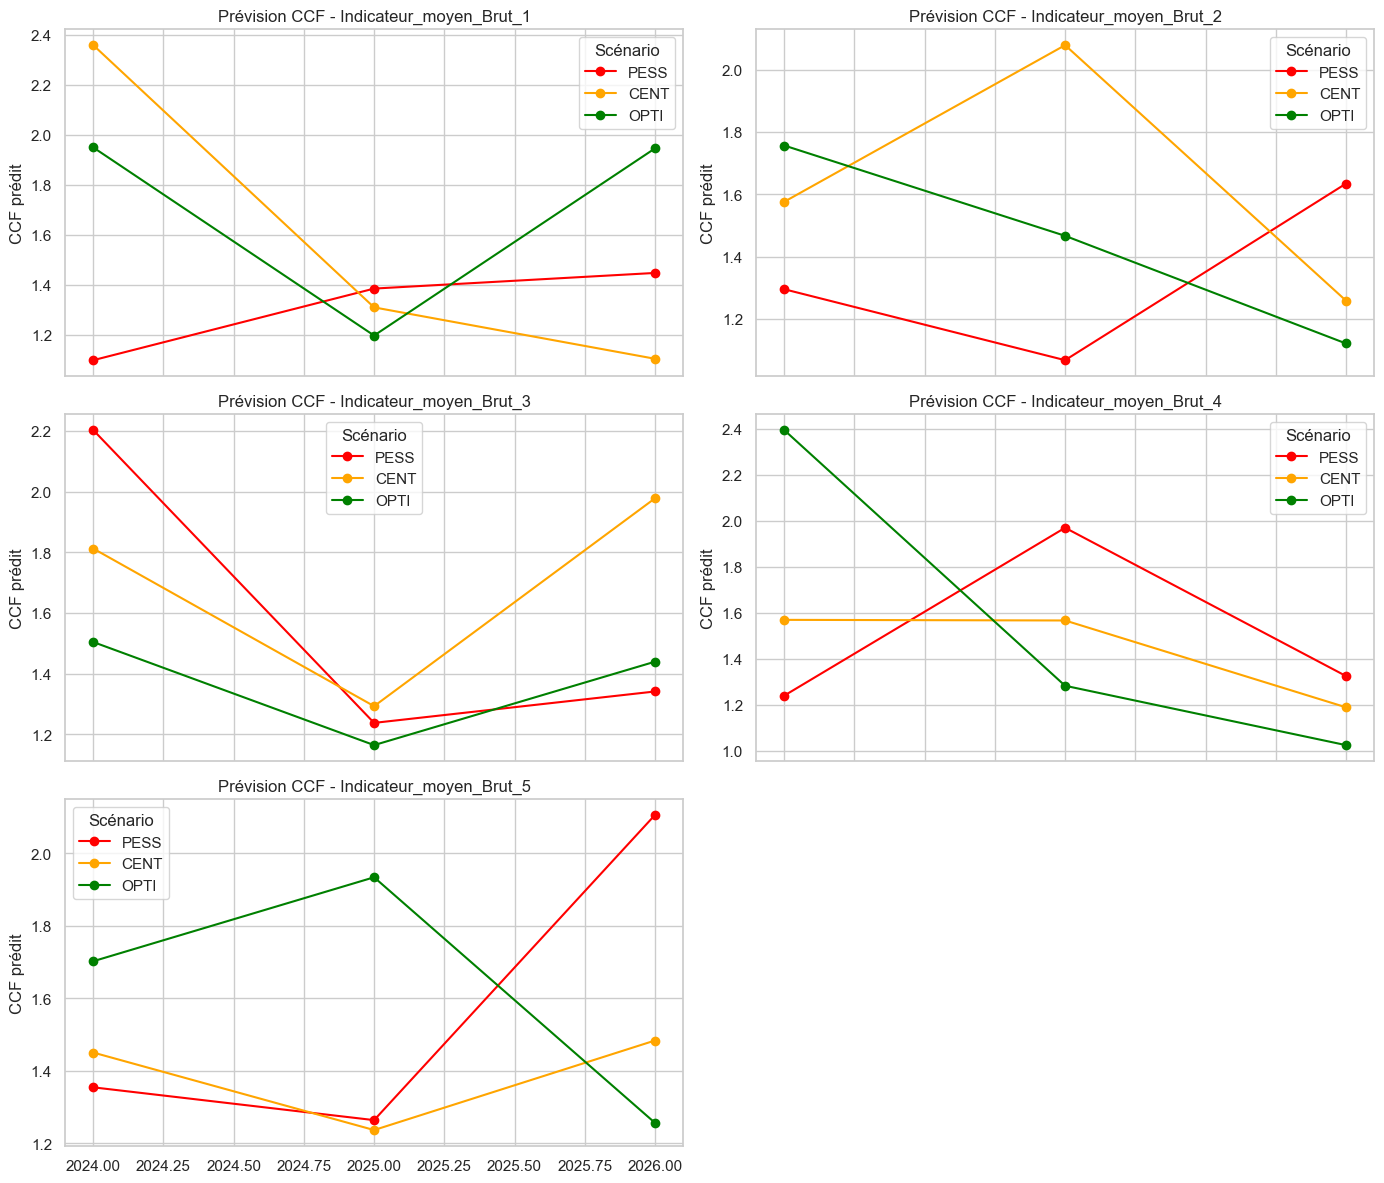

In [ ]:
n_rows = len(projection_df)
segments = [f"Indicateur_moyen_Brut_{i}" for i in range(1, 6)]
projection_df["Segment"] = np.resize(segments, n_rows)  # boucle les noms de segments

# Tri et tracé
projection_df = projection_df.sort_values(by=["Segment", "Année"])
ncols = 2
nrows = (len(segments) + ncols - 1) // ncols
couleurs = {"PESS": "red", "CENT": "orange", "OPTI": "green"}

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=True)
axes = axes.flatten()

for i, segment in enumerate(segments):
    ax = axes[i]
    df_seg = projection_df[projection_df["Segment"] == segment]
    
    for scenario in ["PESS", "CENT", "OPTI"]:
        df_scen = df_seg[df_seg["Scénario"] == scenario]
        ax.plot(df_scen["Année"], df_scen["Prévision_CCF"], 
                marker='o', label=scenario, color=couleurs[scenario])
    
    ax.set_title(f"Prévision CCF - {segment}")
    ax.set_ylabel("CCF prédit")
    ax.grid(True)
    ax.legend(title="Scénario")

# Cacher les axes inutilisés
for j in range(len(segments), len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Année")
plt.tight_layout()
plt.show()
